In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA, WindowAverage

c:\Users\jacks\anaconda3\envs\tech_challenge\Lib\site-packages\statsforecast\core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
def calculate_wmape(actual, forecast, weights=None):
    """
    Calculate the Weighted Mean Absolute Percentage Error (WMAPE) between two series.

    Parameters:
    actual (list or array): The actual values.
    forecast (list or array): The forecasted values.
    weights (list or array, optional): Weight for each observation. Default is None (equal weights).

    Returns:
    float: The calculated WMAPE.
    """
    if len(actual) != len(forecast):
        raise ValueError("Both series must have the same length.")

    if weights is None:
        weights = [1] * len(actual)

    if len(weights) != len(actual):
        raise ValueError("Number of weights must match the length of the series.")

    total_weighted_absolute_percentage_error = 0
    total_weights = sum(weights)

    for i in range(len(actual)):
        abs_percentage_error = abs((actual[i] - forecast[i]) / actual[i]) * 100
        weighted_abs_percentage_error = abs_percentage_error * weights[i]
        total_weighted_absolute_percentage_error += weighted_abs_percentage_error

    wmape_score = total_weighted_absolute_percentage_error / total_weights
    return wmape_score

def calculate_mape(actual, forecast):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between two series.

    Parameters:
    actual (list or array): The actual values.
    forecast (list or array): The forecasted values.

    Returns:
    float: The calculated MAPE.
    """
    if len(actual) != len(forecast):
        raise ValueError("Both series must have the same length.")

    total_absolute_percentage_error = 0

    for i in range(len(actual)):
        abs_percentage_error = abs((actual[i] - forecast[i]) / actual[i]) * 100
        total_absolute_percentage_error += abs_percentage_error

    mape_score = total_absolute_percentage_error / len(actual)
    return mape_score

def calc_wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

def calc_mae (y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / len(y_true)

# Objetivo

Você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA para criar uma série temporal e prever diariamente o fechamento da base.

- Apresentar modelo com storytelling;

- Justificar a técnica utilizada;

- Atingir acurácia mínimia de 70%.

**Dados**: https://br.investing.com/indices/bovespa-historical-data

# Leitura e processamento dos dados

In [3]:
dados_path = './data/dados_ibovespa_2010-2023.csv'

dados = pd.read_csv(dados_path)

dados

Data   Último  Abertura   Máxima   Mínima    Vol.    Var%
0     24.08.2023  117.026   118.135  118.136  116.848   9,20M  -0,94%
1     23.08.2023  118.135   116.160  118.135  116.159  11,54M   1,70%
2     22.08.2023  116.156   114.433  116.286  114.433   9,83M   1,51%
3     21.08.2023  114.429   115.404  115.425  114.067   9,79M  -0,85%
4     18.08.2023  115.409   114.973  115.729  114.423  10,60M   0,37%
...          ...      ...       ...      ...      ...     ...     ...
3376  08.01.2010   70.263    70.455   70.766   70.158   1,63M  -0,27%
3377  07.01.2010   70.451    70.723   70.723   70.045   1,55M  -0,39%
3378  06.01.2010   70.729    70.237   70.937   70.016   2,24M   0,70%
3379  05.01.2010   70.240    70.046   70.595   69.928   1,98M   0,28%
3380  04.01.2010   70.045    68.587   70.081   68.587   1,66M   2,12%

[3381 rows x 7 columns]

In [4]:
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3381 entries, 0 to 3380
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      3381 non-null   object 
 1   Último    3381 non-null   float64
 2   Abertura  3381 non-null   float64
 3   Máxima    3381 non-null   float64
 4   Mínima    3381 non-null   float64
 5   Vol.      3380 non-null   object 
 6   Var%      3381 non-null   object 
dtypes: float64(4), object(3)
memory usage: 185.0+ KB
None


In [5]:
print(dados.isna().sum())

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64


Existem algumas inconsistências na base. Coluna de data está como tipo texto, variáveis numéricas em formato texto e existe um valor nulo na coluna "Vol."

## Ajuste nos tipos de dados

In [6]:
# Coluna Data com tipo datetime
dados = pd.read_csv(dados_path, parse_dates=[0], dayfirst=True)

dados.head()

Data   Último  Abertura   Máxima   Mínima    Vol.    Var%
0 2023-08-24  117.026   118.135  118.136  116.848   9,20M  -0,94%
1 2023-08-23  118.135   116.160  118.135  116.159  11,54M   1,70%
2 2023-08-22  116.156   114.433  116.286  114.433   9,83M   1,51%
3 2023-08-21  114.429   115.404  115.425  114.067   9,79M  -0,85%
4 2023-08-18  115.409   114.973  115.729  114.423  10,60M   0,37%

In [7]:
dados['Vol.'] = dados['Vol.'].str[:-1]
dados['Var%'] = dados['Var%'].str[:-1]

dados['Vol.'] = dados['Vol.'].str.replace(',','.')
dados['Var%'] = dados['Var%'].str.replace(',','.')

dados['Vol.'] = dados['Vol.'].astype(float)
dados['Var%'] = dados['Var%'].astype(float)

In [8]:
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3381 entries, 0 to 3380
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      3381 non-null   datetime64[ns]
 1   Último    3381 non-null   float64       
 2   Abertura  3381 non-null   float64       
 3   Máxima    3381 non-null   float64       
 4   Mínima    3381 non-null   float64       
 5   Vol.      3380 non-null   float64       
 6   Var%      3381 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 185.0 KB
None


## Valores nulos

In [9]:
dados.loc[dados['Vol.'].isna()]

Data  Último  Abertura  Máxima  Mínima  Vol.  Var%
1872 2016-02-10  40.377    40.592  40.592   39.96   NaN -0.53

Por se tratar de apenas uma linha no dataframe, será adotada a técnica de exclusão da linha com valores nulos, pois não prejudicará a representação dos dados.

In [10]:
dados.dropna(inplace=True)

dados.loc[dados['Vol.'].isna()]

Empty DataFrame
Columns: [Data, Último, Abertura, Máxima, Mínima, Vol., Var%]
Index: []

## Renomeando colunas

Para facilitar as análises futuras e simplificar a nomenclatura das variáveis, os nomes das colunas também serão modificados

In [11]:
print(dados.columns)

Index(['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], dtype='object')


In [12]:
dados.columns = ['ds', 'y', 'abertura', 'max', 'min', 'volume', 'variacao']

dados.head()

ds        y  abertura      max      min  volume  variacao
0 2023-08-24  117.026   118.135  118.136  116.848    9.20     -0.94
1 2023-08-23  118.135   116.160  118.135  116.159   11.54      1.70
2 2023-08-22  116.156   114.433  116.286  114.433    9.83      1.51
3 2023-08-21  114.429   115.404  115.425  114.067    9.79     -0.85
4 2023-08-18  115.409   114.973  115.729  114.423   10.60      0.37

## Exportação da base processada

In [13]:
dados.to_csv('./data/dados_ibovespa_2010-2023_processed.csv', index=False)

# Exploratory Data Analysis

## Variação

In [14]:
print(f'Variação máxima (%): {dados.variacao.max()}')
print(dados.loc[dados.variacao == dados.variacao.max()]['ds'])

print('\n')

print(f'Variação mínima (%): {dados.variacao.min()}')
print(dados.loc[dados.variacao == dados.variacao.min()]['ds'])

Variação máxima (%): 13.91
859   2020-03-13
Name: ds, dtype: datetime64[ns]


Variação mínima (%): -14.78
860   2020-03-12
Name: ds, dtype: datetime64[ns]


Os picos de variação máxima e mínima do índica IBOVESPA ocorreram em períodos bem próximos na linha do tempo.

Tanto o máximo de desvalorização  como o de valorização da bolsa ocorreram no ano de 2020, provavelmente efeito da pandemia. É um alerta de como esse ano foi atípico, tais dados podem não ser bons conjuntos de treino e teste

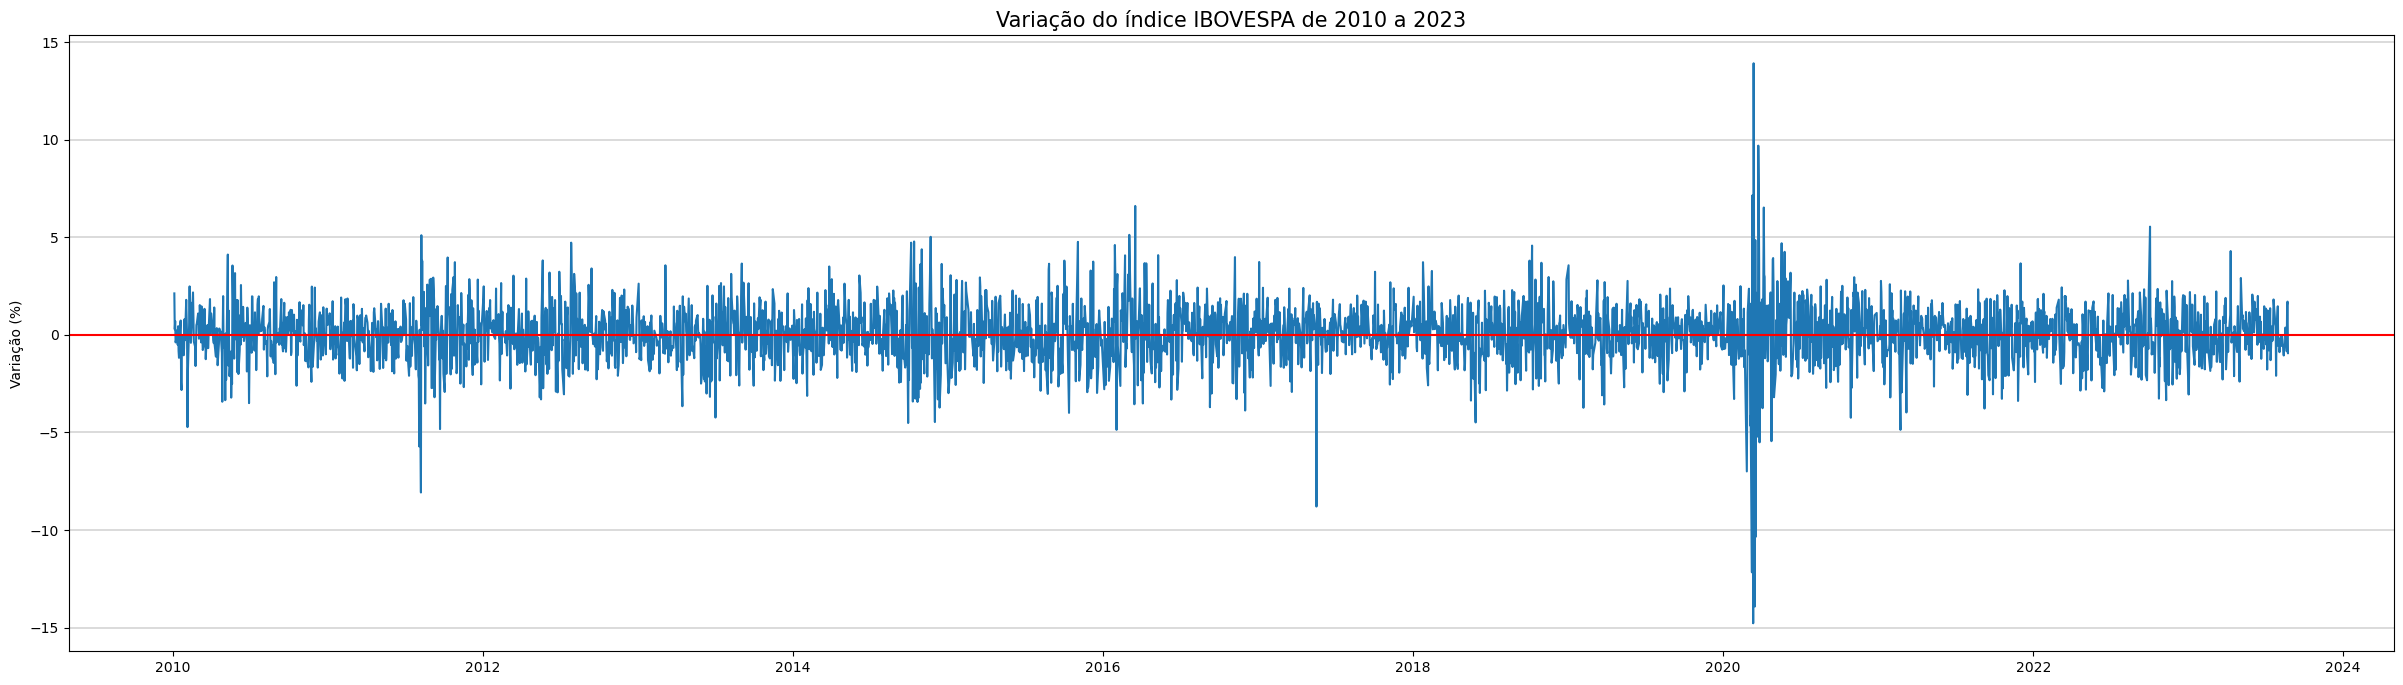

In [15]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados, x='ds', y='variacao', ax=ax)
ax.axhline(y=0, color='red')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Variação do índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Variação (%)')

plt.show()

Percebe-se um gráfico com muitos altos e baixos, porém com a maioria dos valores entre -5% e +5% de variação. 

Ocorrem alguns pontos no gráfico em que a variação ultrapassa esses valores, com destaque novamente para o ano de 2020 que apresentou o comportamento mais incostante na série.

## Volume

Total de valores negociados no dia, em milhões R$

In [16]:
print(f'Volume máximo (milhões R$): {dados.volume.max()}')
print(dados.loc[dados.volume == dados.volume.max()]['ds'])

print('\n')

print(f'Volume mínimo (milhões R$): {dados.volume.min()}')
print(dados.loc[dados.volume == dados.volume.min()]['ds'])

Volume máximo (milhões R$): 981.63
3158   2010-11-25
Name: ds, dtype: datetime64[ns]


Volume mínimo (milhões R$): 1.0
3009   2011-07-04
Name: ds, dtype: datetime64[ns]


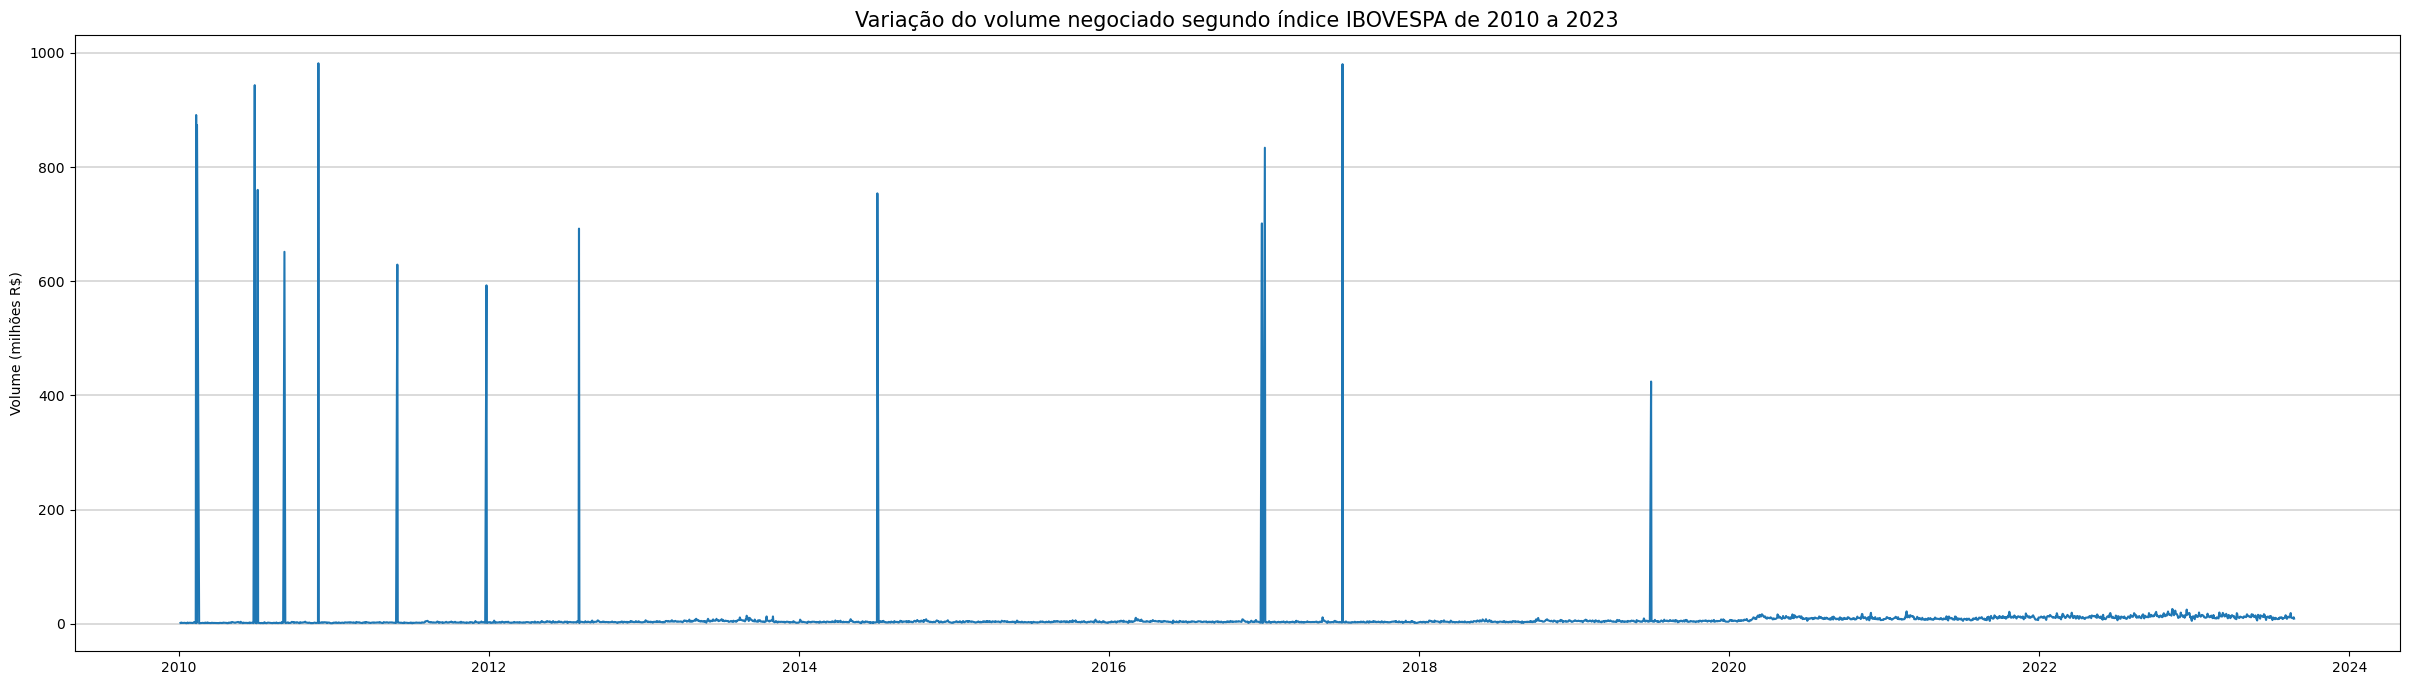

In [17]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados, x='ds', y='volume', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Variação do volume negociado segundo índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Volume (milhões R$)')

plt.show()

O gráfico indica outliers muito acima do normal para os valores de volume negociados em bolsa, é um indício que a base de dados pode ter inconsistências nesse sentido.

Checando na base original, foi verificado que existiam valores na unidade de milhares de R$ em meio à grande maioria das linhas representadas em milhões de R$. Ou seja, os outliers que surgiram na verdade devem ser divididos por 1000 para ajustá-los para a unidade milhões de R$

In [18]:
# Linhas da base com volume em milhares de R$
dados.loc[dados.volume > 100]

ds        y  abertura      max      min  volume  variacao
1034 2019-07-01  101.340   100.973  102.432  100.973  424.32      0.37
1523 2017-07-04   63.232    63.268   63.346   63.076  980.07     -0.08
1647 2017-01-02   59.589    60.227   60.227   59.371  833.73     -1.06
1651 2016-12-26   58.620    57.941   58.781   57.941  701.23      1.18
2266 2014-07-04   54.056    53.893   54.087   53.704  753.84      0.34
2740 2012-07-31   56.097    57.243   57.466   56.097  692.08     -2.00
2888 2011-12-26   57.669    57.702   57.856   57.669  592.75     -0.05
3033 2011-05-30   63.954    64.295   64.460   63.915  629.04     -0.53
3158 2010-11-25   69.362    69.634   69.780   69.362  981.63     -0.38
3212 2010-09-06   66.747    66.679   66.949   66.380  651.48      0.10
3256 2010-07-05   60.865    61.436   61.667   60.796  759.93     -0.92
3261 2010-06-28   64.225    64.825   65.105   64.225  943.30     -0.92
3352 2010-02-12   65.855    66.129   66.133   65.123  873.28     -0.41
3354 2010-02-10   65.051    64.721   65.170   64.320  891.04      0.51

In [19]:
# Conversão para milhões de R$
dados.loc[dados.volume > 100, 'volume'] = dados.volume/1000

In [20]:
dados.loc[dados.volume > 100]

Empty DataFrame
Columns: [ds, y, abertura, max, min, volume, variacao]
Index: []

In [21]:
print(f'Volume máximo (milhões R$): {dados.volume.max()}')
print(dados.loc[dados.volume == dados.volume.max()]['ds'])

print('\n')

print(f'Volume mínimo (milhões R$): {dados.volume.min()}')
print(dados.loc[dados.volume == dados.volume.min()]['ds'])

Volume máximo (milhões R$): 26.03
197   2022-11-10
Name: ds, dtype: datetime64[ns]


Volume mínimo (milhões R$): 0.42432
1034   2019-07-01
Name: ds, dtype: datetime64[ns]


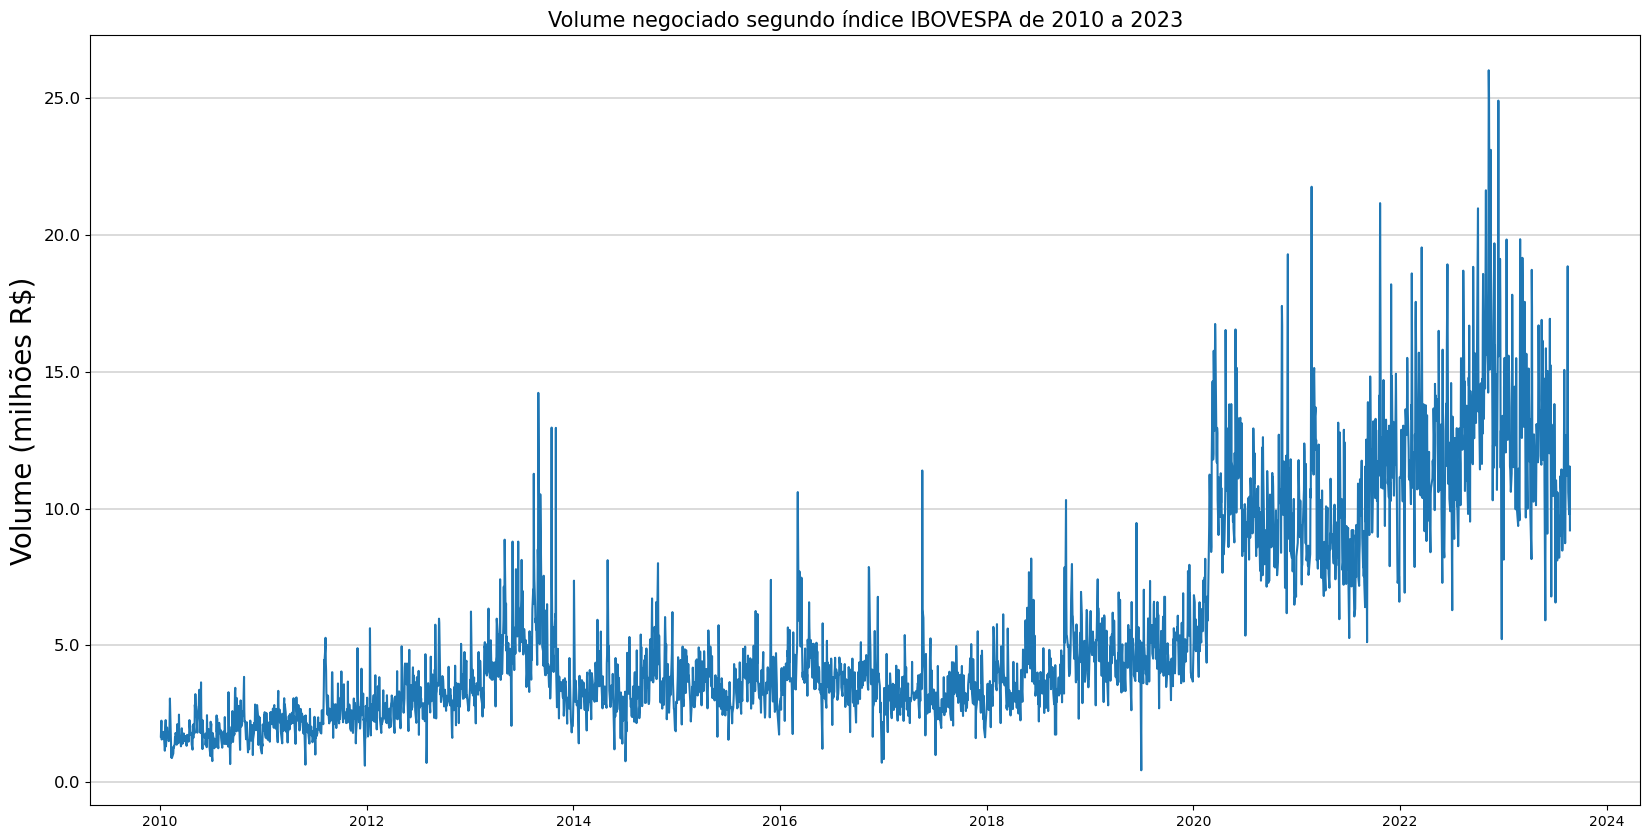

In [102]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(dados, x='ds', y='volume', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Volume negociado segundo índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Volume (milhões R$)', fontsize=20)
ax.set_yticklabels(ax.get_yticks(), fontsize=12)
#ax.set_xticklabels(ax.get_xticks(), fontsize=15)

plt.show()

Agora, o gráfico ilustra bem a evolução do mercado variável no Brasil. É visível que, até meados de 2019, o volume de negociações sofreu pouca alteração com uma leve tendência de crescimento.

Com a redução nas taxas de juros e Selic, e consequentemente a baixa nos investimentos de Renda Fixa, o mercado de Renda Variável teve um "boom" a partir do ano de 2020.

https://www.cnnbrasil.com.br/economia/numero-de-investidores-na-bolsa-cresce-15-em-2022-apostando-na-diversificacao/

## Diferença entre índice mínimo e máximo diário

Com a diferença entre as variáveis "min" e "max" é possível identificar dias em que o índice IBOVESPA sofreu maior alteração durante as próprias negociações do dia. 

Desta forma, pode-se verificar dias atípicos, possivelmente causados por fatores e eventos político-econômicos importantes, que resultaram na flutuação do índice durante o período de um dia.

In [23]:
dados['dif_min_max'] = dados['max'] - dados['min']
dados

ds        y  abertura      max      min  volume  variacao  \
0    2023-08-24  117.026   118.135  118.136  116.848    9.20     -0.94   
1    2023-08-23  118.135   116.160  118.135  116.159   11.54      1.70   
2    2023-08-22  116.156   114.433  116.286  114.433    9.83      1.51   
3    2023-08-21  114.429   115.404  115.425  114.067    9.79     -0.85   
4    2023-08-18  115.409   114.973  115.729  114.423   10.60      0.37   
...         ...      ...       ...      ...      ...     ...       ...   
3376 2010-01-08   70.263    70.455   70.766   70.158    1.63     -0.27   
3377 2010-01-07   70.451    70.723   70.723   70.045    1.55     -0.39   
3378 2010-01-06   70.729    70.237   70.937   70.016    2.24      0.70   
3379 2010-01-05   70.240    70.046   70.595   69.928    1.98      0.28   
3380 2010-01-04   70.045    68.587   70.081   68.587    1.66      2.12   

      dif_min_max  
0           1.288  
1           1.976  
2           1.853  
3           1.358  
4           1.306  
...           ...  
3376        0.608  
3377        0.678  
3378        0.921  
3379        0.667  
3380        1.494  

[3380 rows x 8 columns]

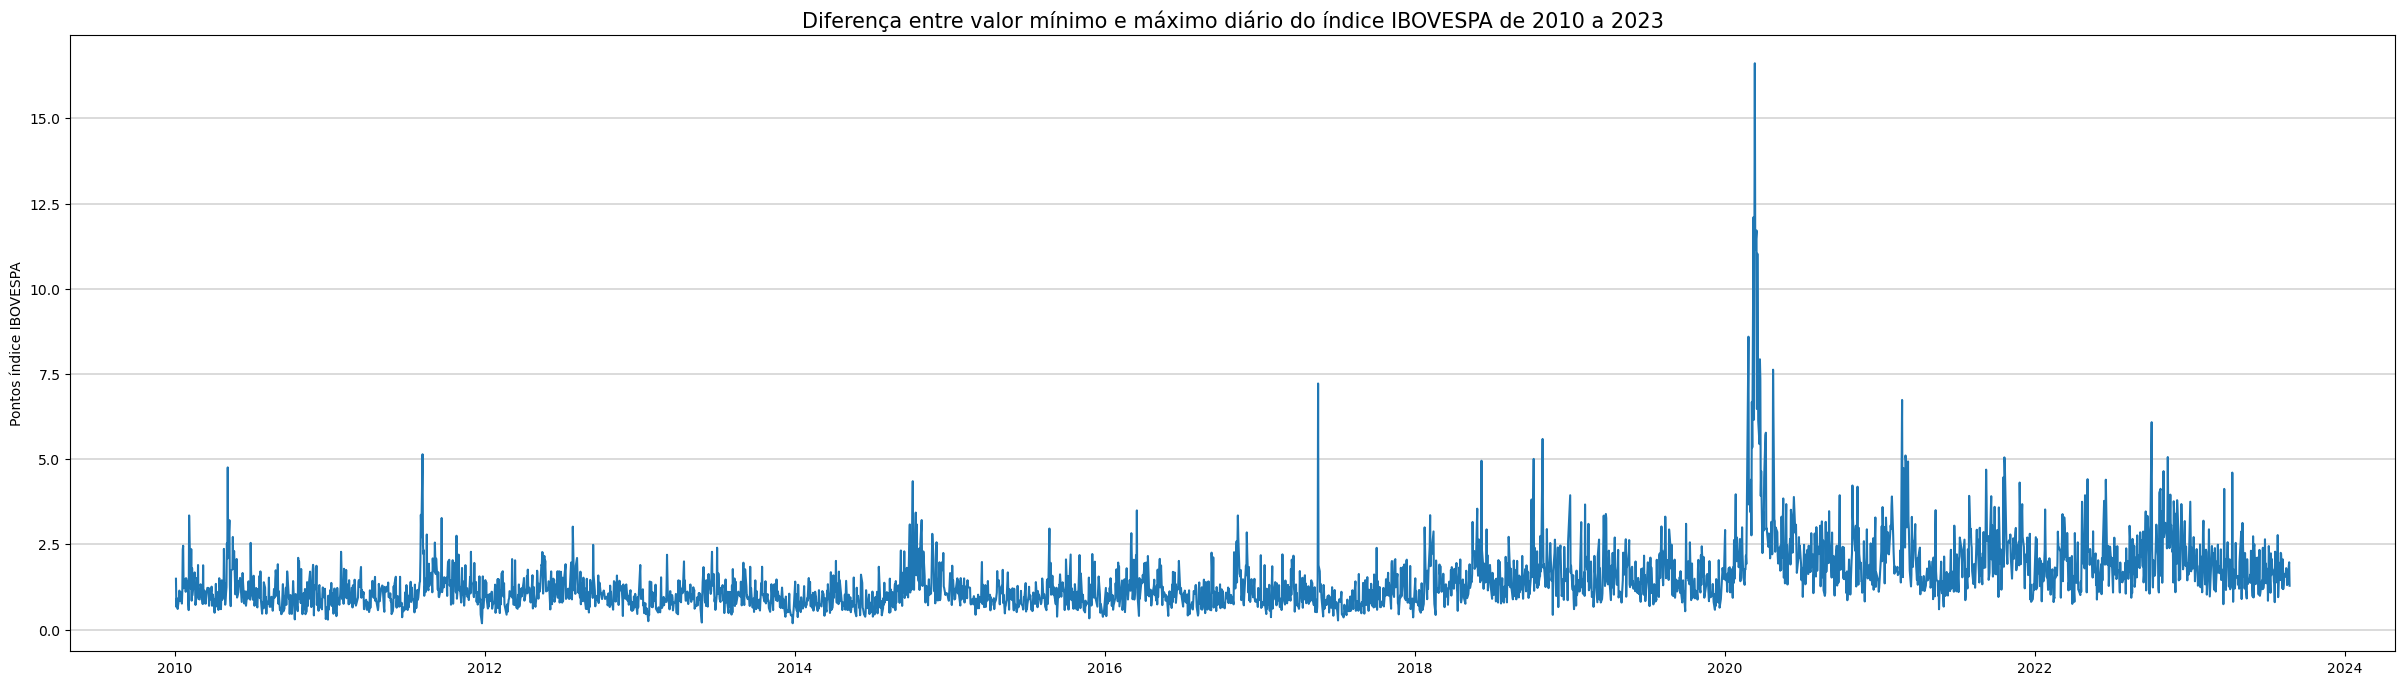

In [24]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados, x='ds', y='dif_min_max', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Diferença entre valor mínimo e máximo diário do índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

In [25]:
print('Número de dias com diferença entre mínimo e máximo maior que 5%:')
dados.loc[dados.dif_min_max > 5].ds.dt.year.value_counts()

Número de dias com diferença entre mínimo e máximo maior que 5%:


ds
2020    19
2021     3
2022     2
2018     2
2017     1
2011     1
Name: count, dtype: int64

Este resultado reforça mais uma vez o comportamento atípico do IBOVESPA a partir de 2020. Possivelmente, 2021 e 2022 aparecem em seguida no rankin também por reflexo dos efeitos da crise causada pela pandemia.

## Fechamento

In [26]:
print(f'Índice máximo no fechamento: {dados.y.max()}')
print(dados.loc[dados.y == dados.y.max()]['ds'])

print('\n')

print(f'Índice máximo no fechamento: {dados.y.min()}')
print(dados.loc[dados.y == dados.y.min()]['ds'])

Índice máximo no fechamento: 130.776
555   2021-06-07
Name: ds, dtype: datetime64[ns]


Índice máximo no fechamento: 37.497
1881   2016-01-26
Name: ds, dtype: datetime64[ns]


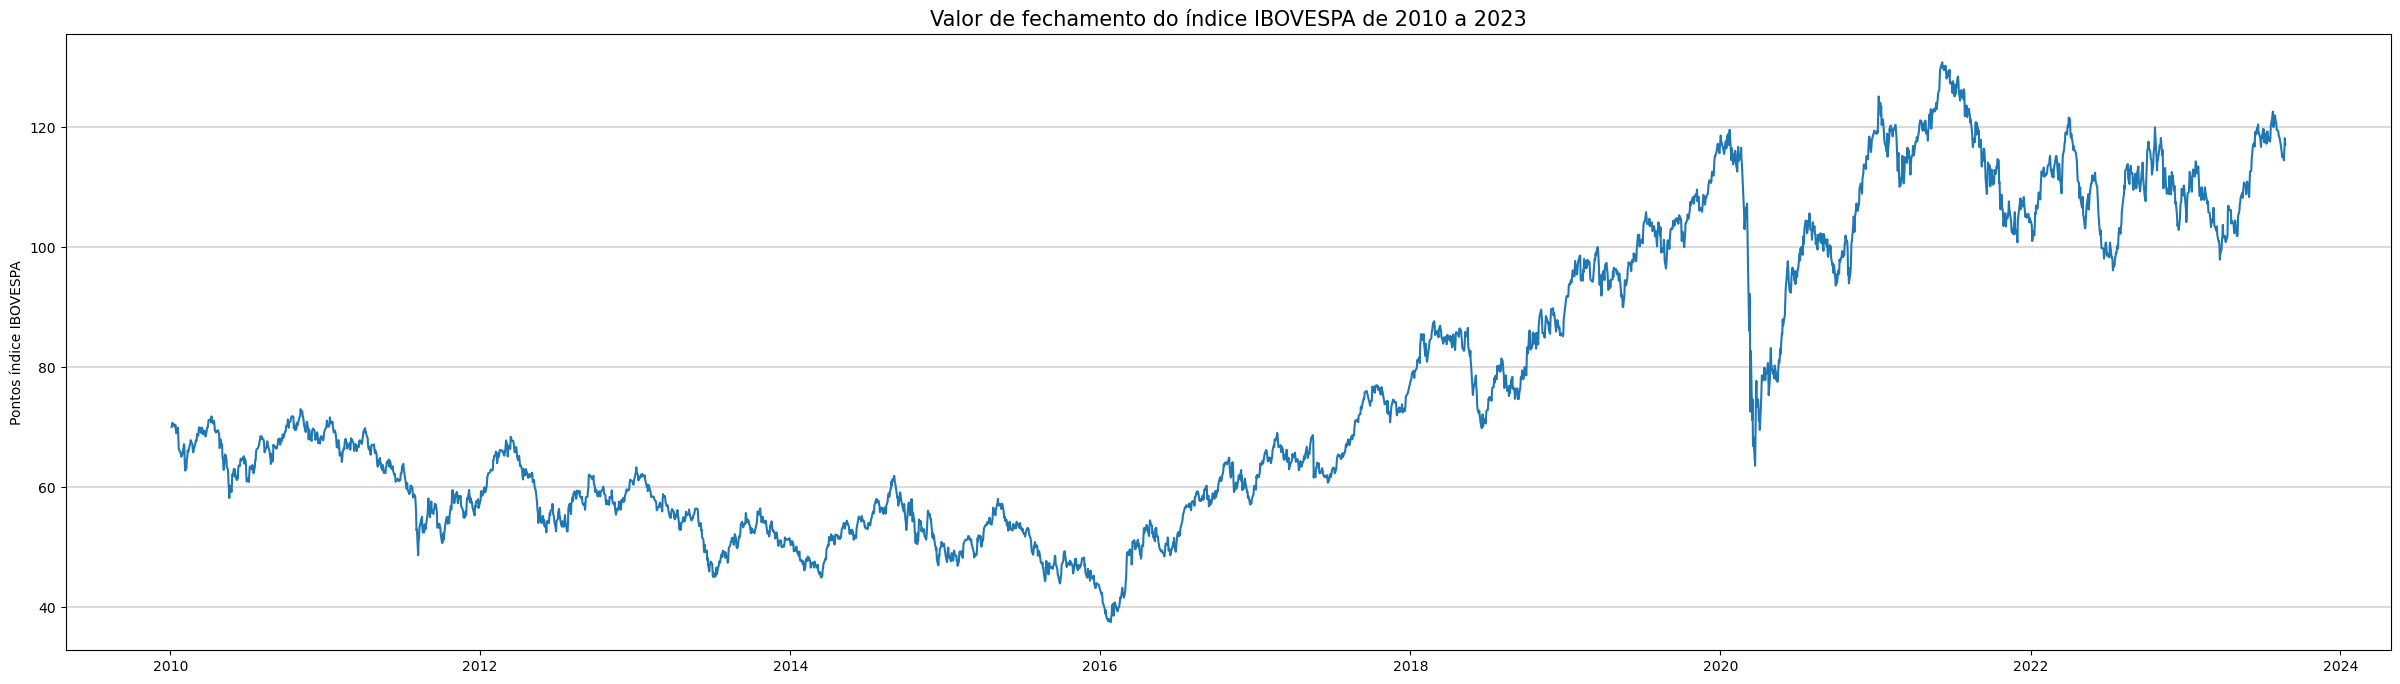

In [27]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados, x='ds', y='y', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Valor de fechamento do índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

Analisando a série temporal do valor de fechamento diário do IBOVESPA, de maneira geral ficam evidentes quatro momentos distintos:

1. Tendência de queda de 2010 a 2016
2. Alta tendência de subida entre 2016 e 2020
3. Queda abrupta com a pandemia em 2020
4. Retomada da normalidade a partir do final de 2021, com série variando em momentos de queda e alta

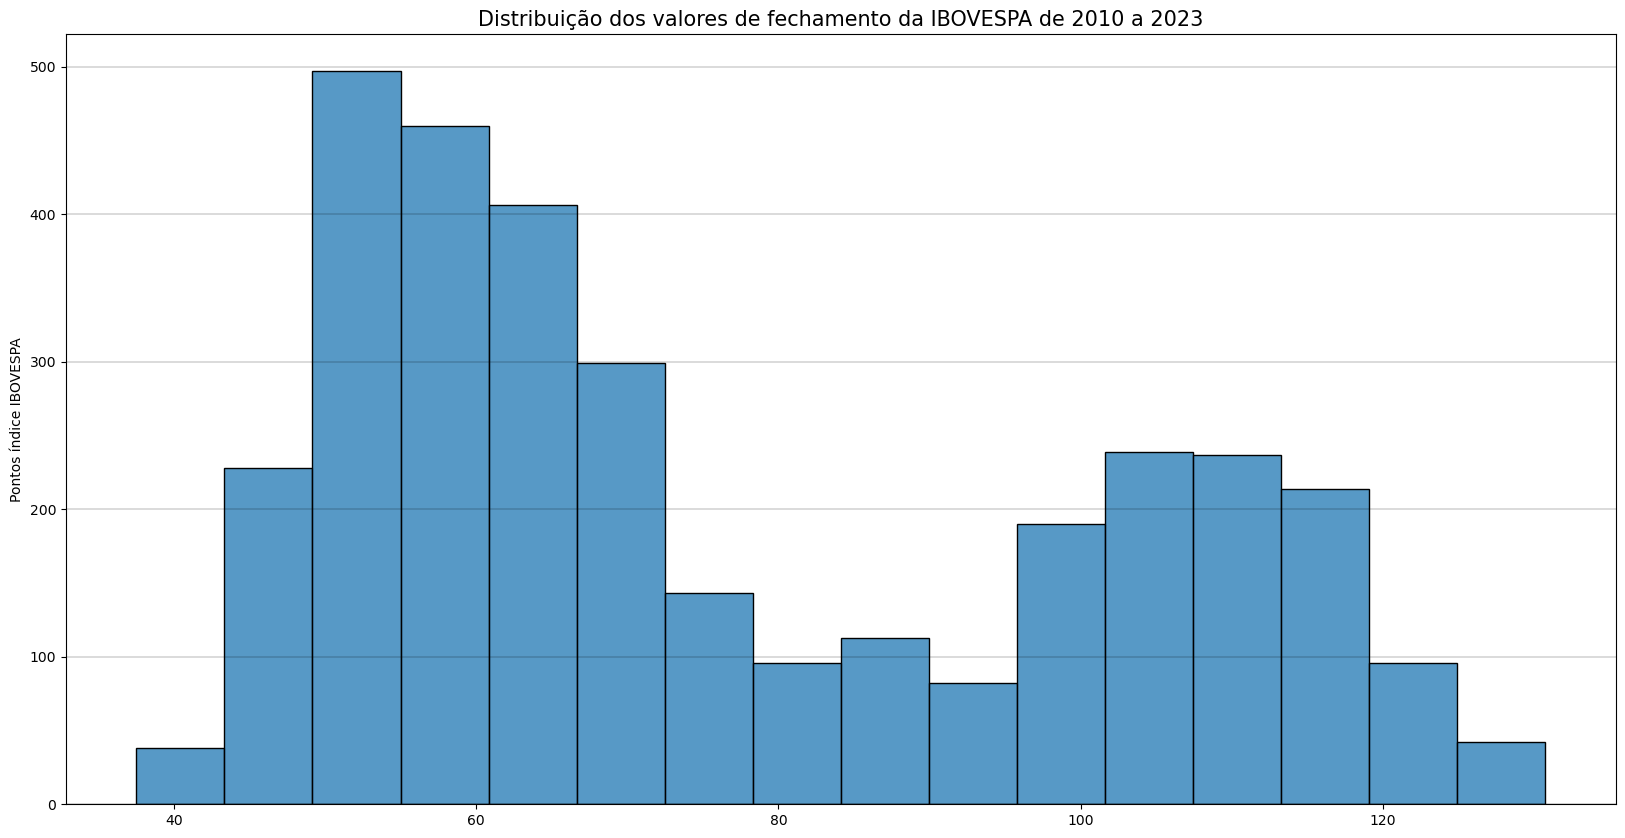

In [28]:
fig, ax = plt.subplots(figsize=(20,10))

sns.histplot(dados, x='y', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Distribuição dos valores de fechamento da IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

A série temporal se divide em basicamente dois grupos de acordo com o valor de fechamento. Primeiramente, o maior grupo que representa dias com valor de fechamento entre 50 e 80 pontos, relacionado principalmente aos de 2010 a 2016.

Já o segundo grande grupo concentra dias com valor de fechamento superior aos 100 pontos. Este grupo está relacionado principalmente ao período posterior ao ano de 2019.

## Volume x Fechamento

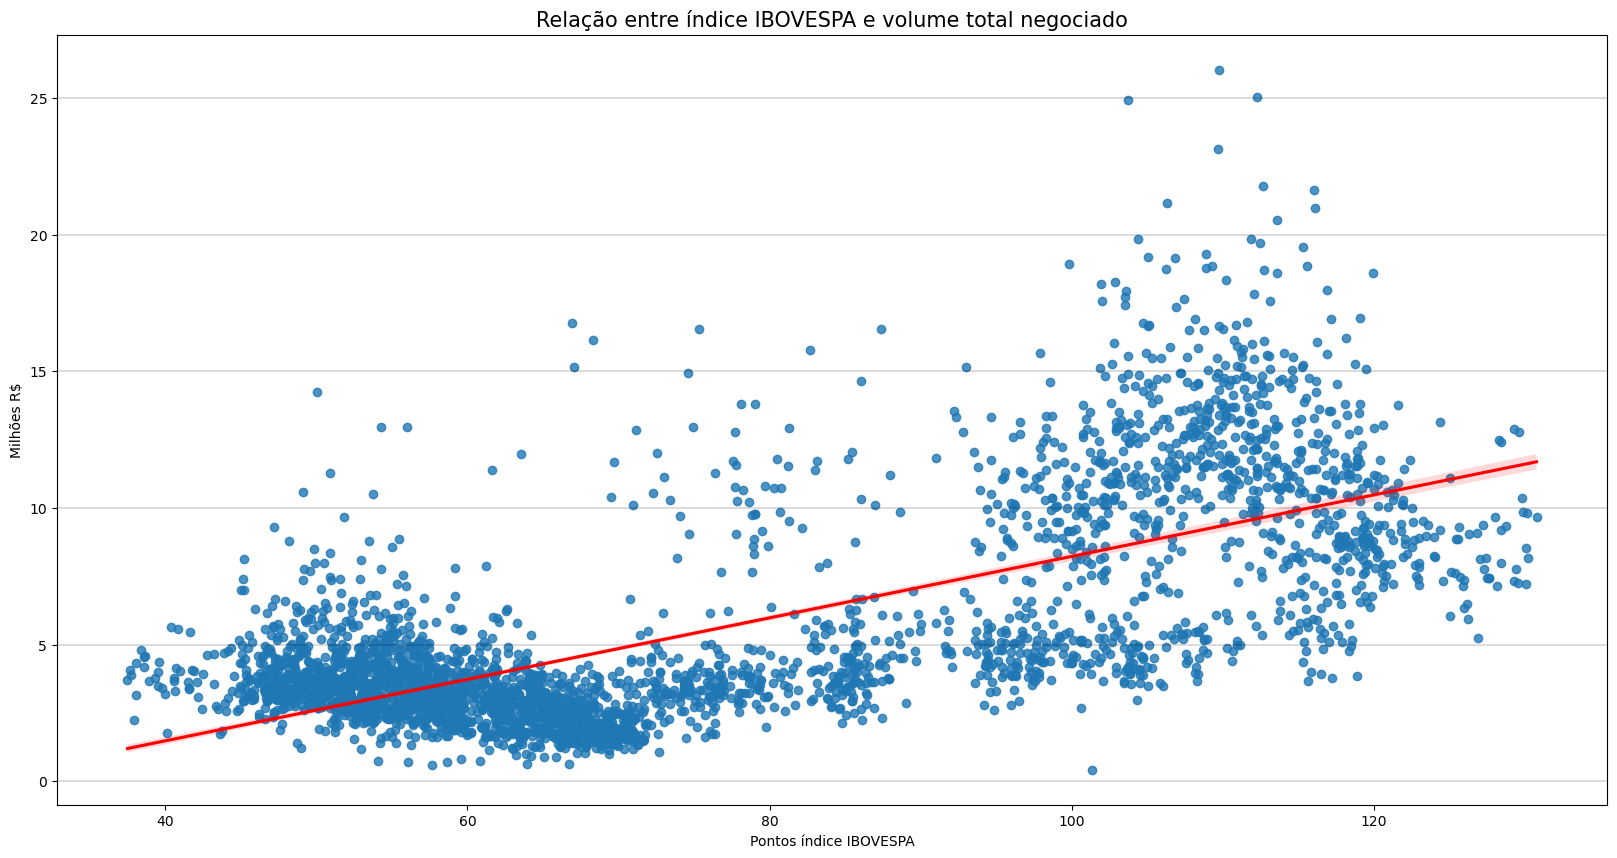

In [29]:
fig, ax = plt.subplots(figsize=(20,10))

sns.regplot(dados, x='y', y='volume', ax=ax, line_kws={'color':'red'})

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Relação entre índice IBOVESPA e volume total negociado', fontsize=15)
ax.set_xlabel('Pontos índice IBOVESPA')
ax.set_ylabel('Milhões R$')

plt.show()

In [30]:
print(dados[['y','volume']].corr())

               y    volume
y       1.000000  0.698497
volume  0.698497  1.000000


Neste gráfico de dispersão é possível visualizar uma forte correlação entre o valor do índice IBOVESPA e o volume negociado em bolsa. A correlação calculada é de 0.70, também um valor bastante alto.

# Série temporal original

## Componentes da série

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

Para ser possível visualizar as componentes da série, é necessário preencher as lacunas na série temporal causada por fins de semana e feriados.

Será utilizado o método ffill, que preenche valores NaN com o último valor válido da coluna.

In [32]:
# DataFrame com Index datetime
dados_date_index = dados[['ds','y']].copy()
dados_date_index.index = pd.to_datetime(dados_date_index.ds, format='%Y-%m-%d')
dados_date_index.drop(columns=['ds'], inplace=True)
dados_date_index = dados_date_index.asfreq('d')
dados_date_index.fillna(method='ffill', inplace=True)
display(dados_date_index)

# Dataframe com coluna datetime e unique_id
dados_date_col = dados_date_index.reset_index()
dados_date_col['unique_id'] = 'ibovespa'
display(dados_date_col)

y
ds                 
2010-01-04   70.045
2010-01-05   70.240
2010-01-06   70.729
2010-01-07   70.451
2010-01-08   70.263
...             ...
2023-08-20  115.409
2023-08-21  114.429
2023-08-22  116.156
2023-08-23  118.135
2023-08-24  117.026

[4981 rows x 1 columns]

ds        y unique_id
0    2010-01-04   70.045  ibovespa
1    2010-01-05   70.240  ibovespa
2    2010-01-06   70.729  ibovespa
3    2010-01-07   70.451  ibovespa
4    2010-01-08   70.263  ibovespa
...         ...      ...       ...
4976 2023-08-20  115.409  ibovespa
4977 2023-08-21  114.429  ibovespa
4978 2023-08-22  116.156  ibovespa
4979 2023-08-23  118.135  ibovespa
4980 2023-08-24  117.026  ibovespa

[4981 rows x 3 columns]

In [33]:
result = seasonal_decompose(dados_date_index)

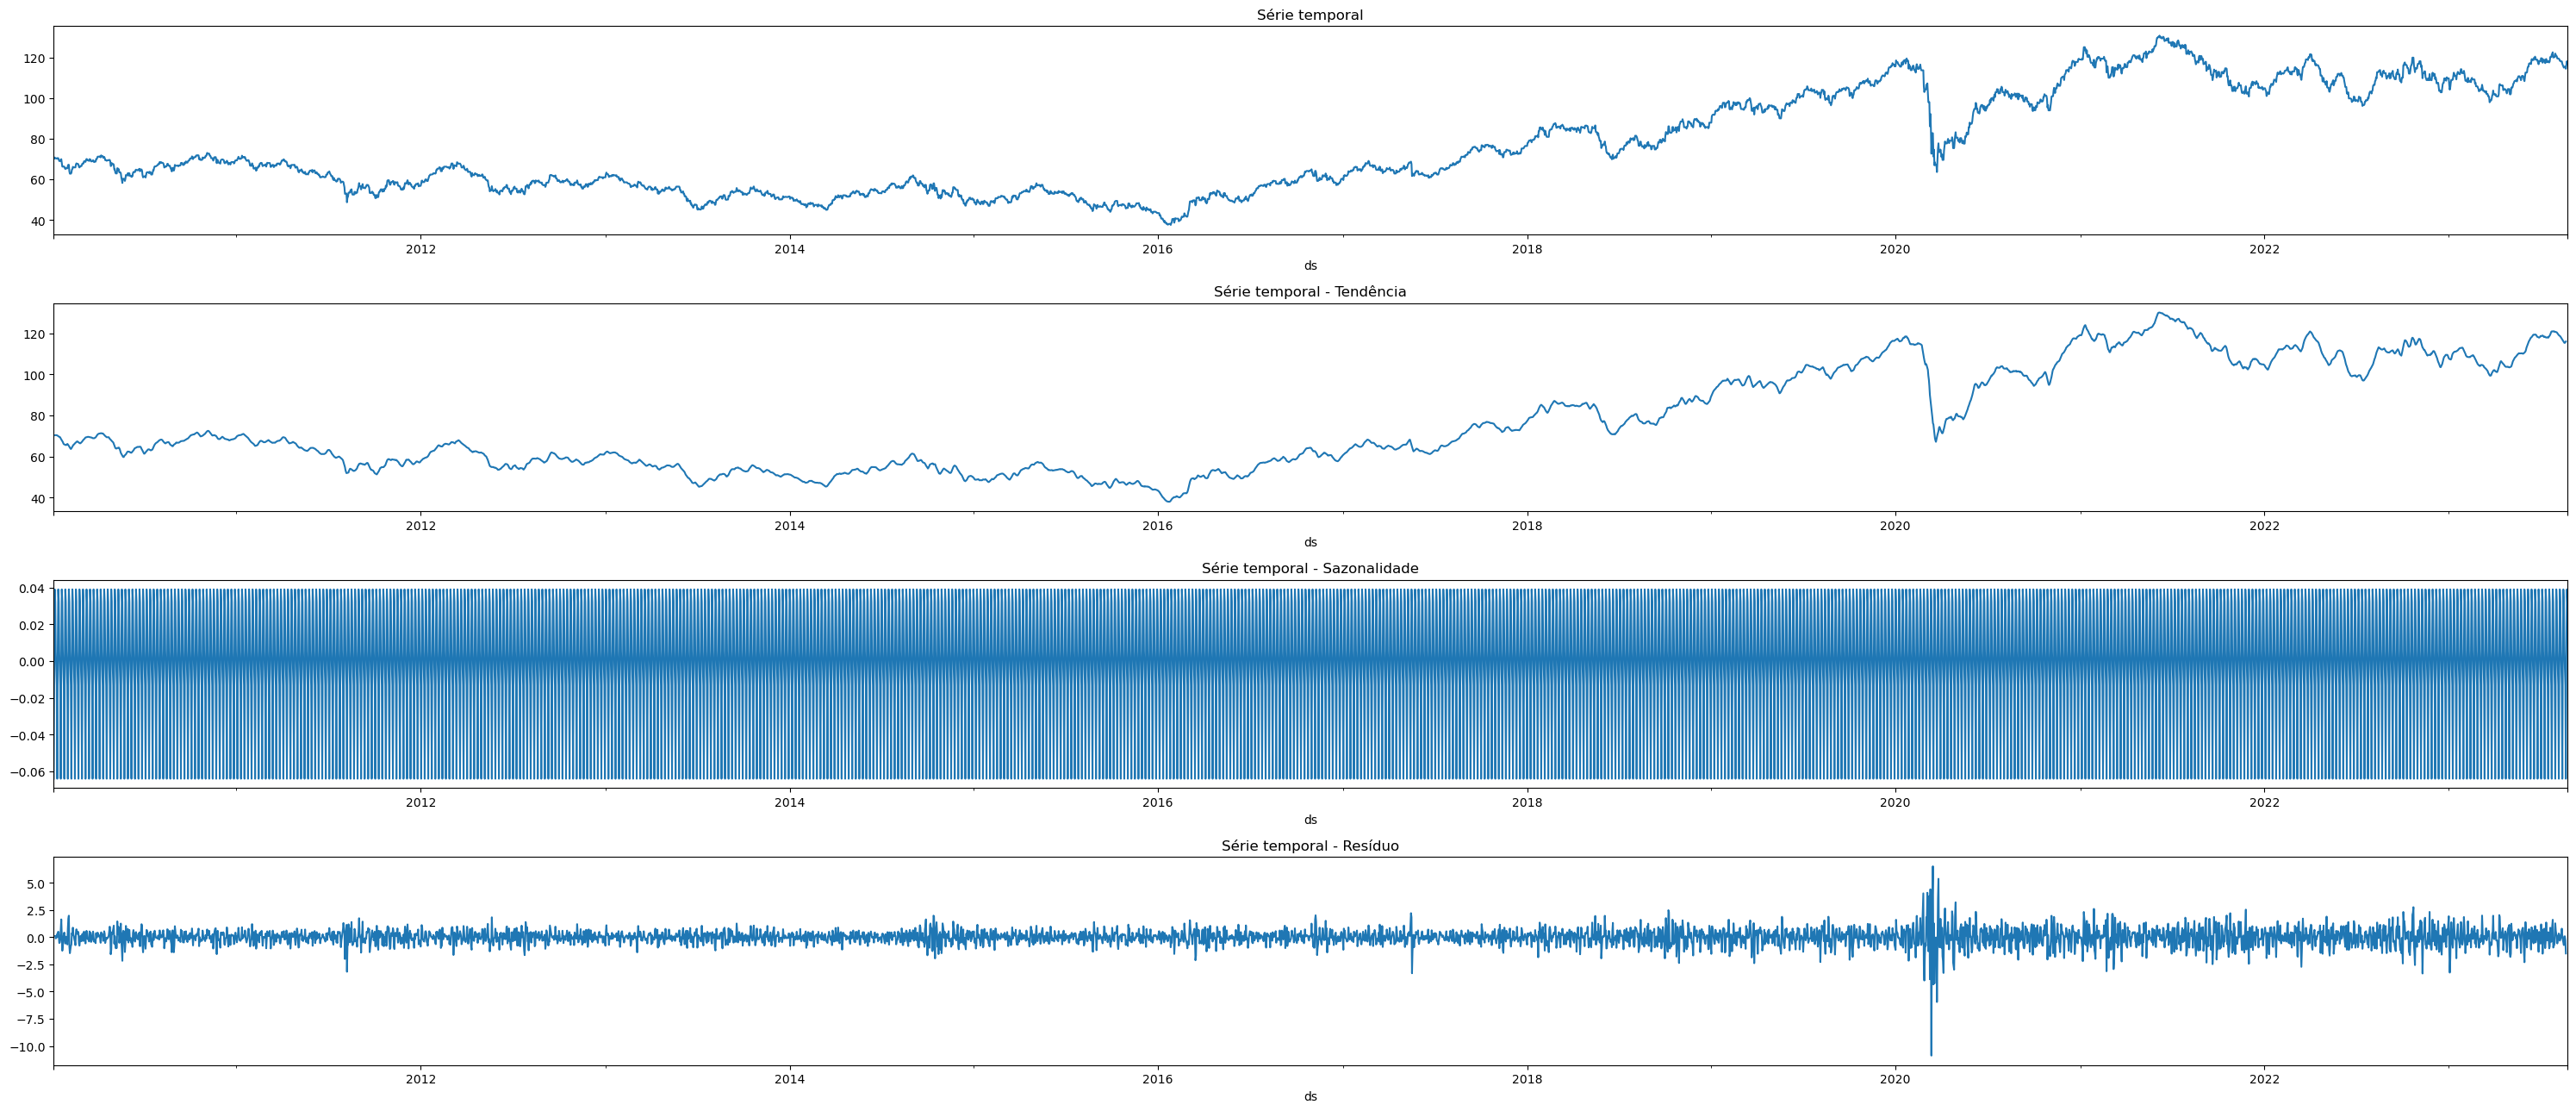

In [34]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.set_title('Série temporal')
ax2.set_title('Série temporal - Tendência')
ax3.set_title('Série temporal - Sazonalidade')
ax4.set_title('Série temporal - Resíduo')

plt.tight_layout()

Não foi possível extrair insights muito valiosos com a decomposição da série temporal em seus componentes. A tendência representa a mesma curva da própria série porém um pouco mais suavizada.

A sazonalidade têm padrão caótico, indicando que não é sazonalidade aparente nos dados, o que faz bastante sentido.

Já o resíduo reforça a ideia de 2020 ser um ano fora do padrão de comportamento da curva.

## Teste ADF

- Teste ADF -> verificar se uma série temporal é estacionária ou não

- H0 = hipótese nula (não é estacionária)
- H1 = hipótese alternativa (é estacionária)

In [35]:
from statsmodels.tsa.stattools import adfuller

result_adfuller = adfuller(dados_date_index.y)

In [36]:
print('Teste ADF')

print(f'Teste estatístico: {result_adfuller[0]}')
print(f'P-value: {result_adfuller[1]}')
print('\n')

print('Valores críticos:')
for key,value in result_adfuller[4].items():
    print(f'{key}: {value}')

Teste ADF
Teste estatístico: -0.9930767867580185
P-value: 0.7557810012330982


Valores críticos:
1%: -3.4316669649844727
5%: -2.8621219552891963
10%: -2.5670797756478825


Não é estacionária!

## Média móvel

In [37]:
# Rolling = calcula estatísticas com base em intervalos no df. Neste caso, média móvel
ma = dados_date_index.rolling(12). mean()

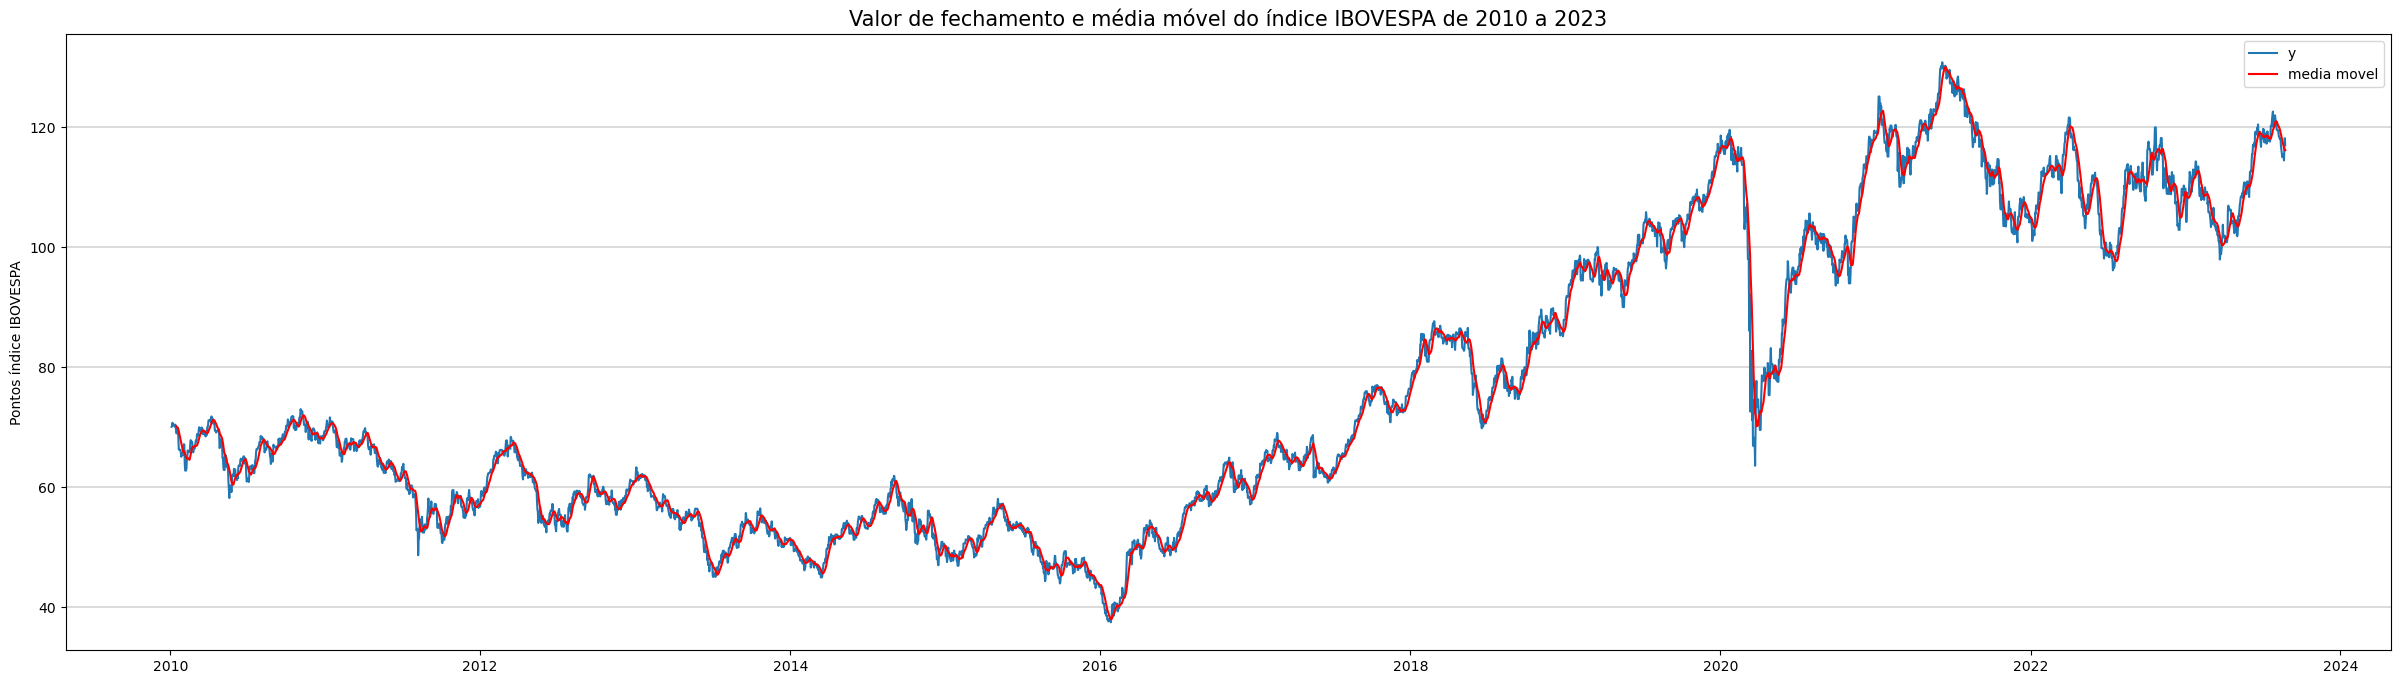

In [38]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados_date_index, x='ds', y='y', ax=ax, label='y')
sns.lineplot(ma, x='ds', y='y', ax=ax, color='r', label='media movel')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('Valor de fechamento e média móvel do índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

Assim como a componente de tendência, a média móvel parece representar o mesmo comportamento da série original porém de maneira suavizada

# Série temporal com transformada logarítmica

## Média móvel

In [39]:
dados_log = np.log(dados_date_index)
ma_log = dados_log.rolling(12).mean()

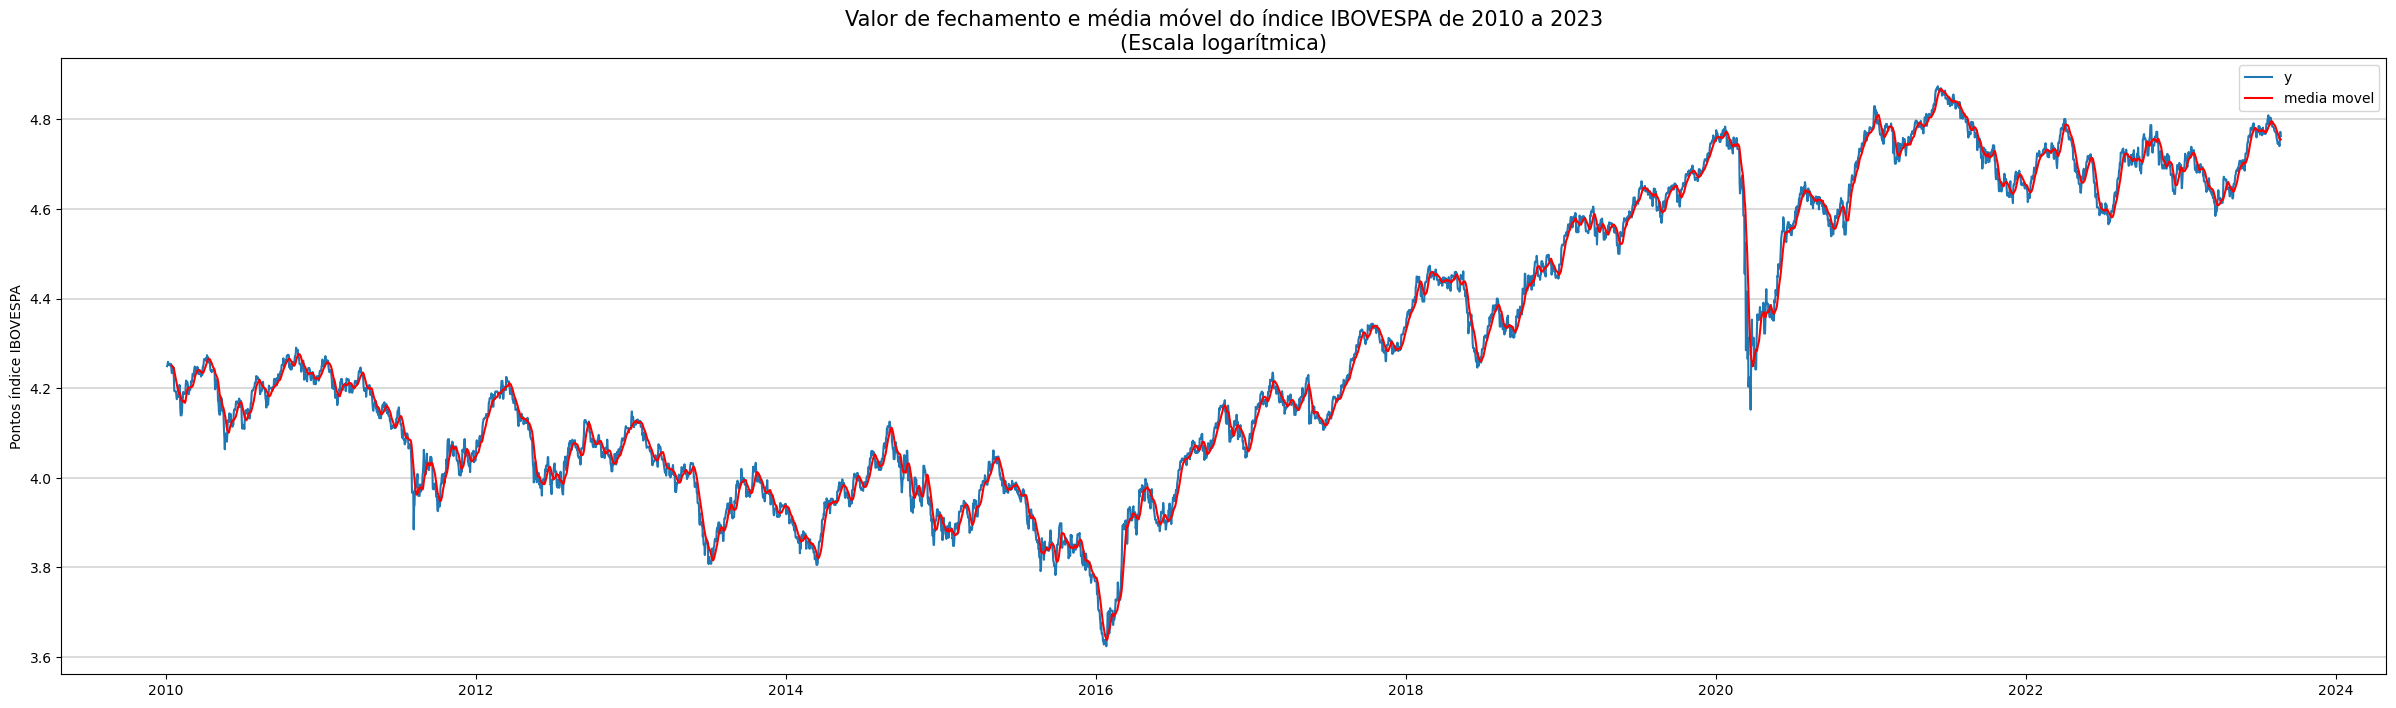

In [40]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados_log, x='ds', y='y', ax=ax, label='y')
sns.lineplot(ma_log, x='ds', y='y', ax=ax, color='r', label='media movel')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('Valor de fechamento e média móvel do índice IBOVESPA de 2010 a 2023\n(Escala logarítmica)', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

## Componentes da série

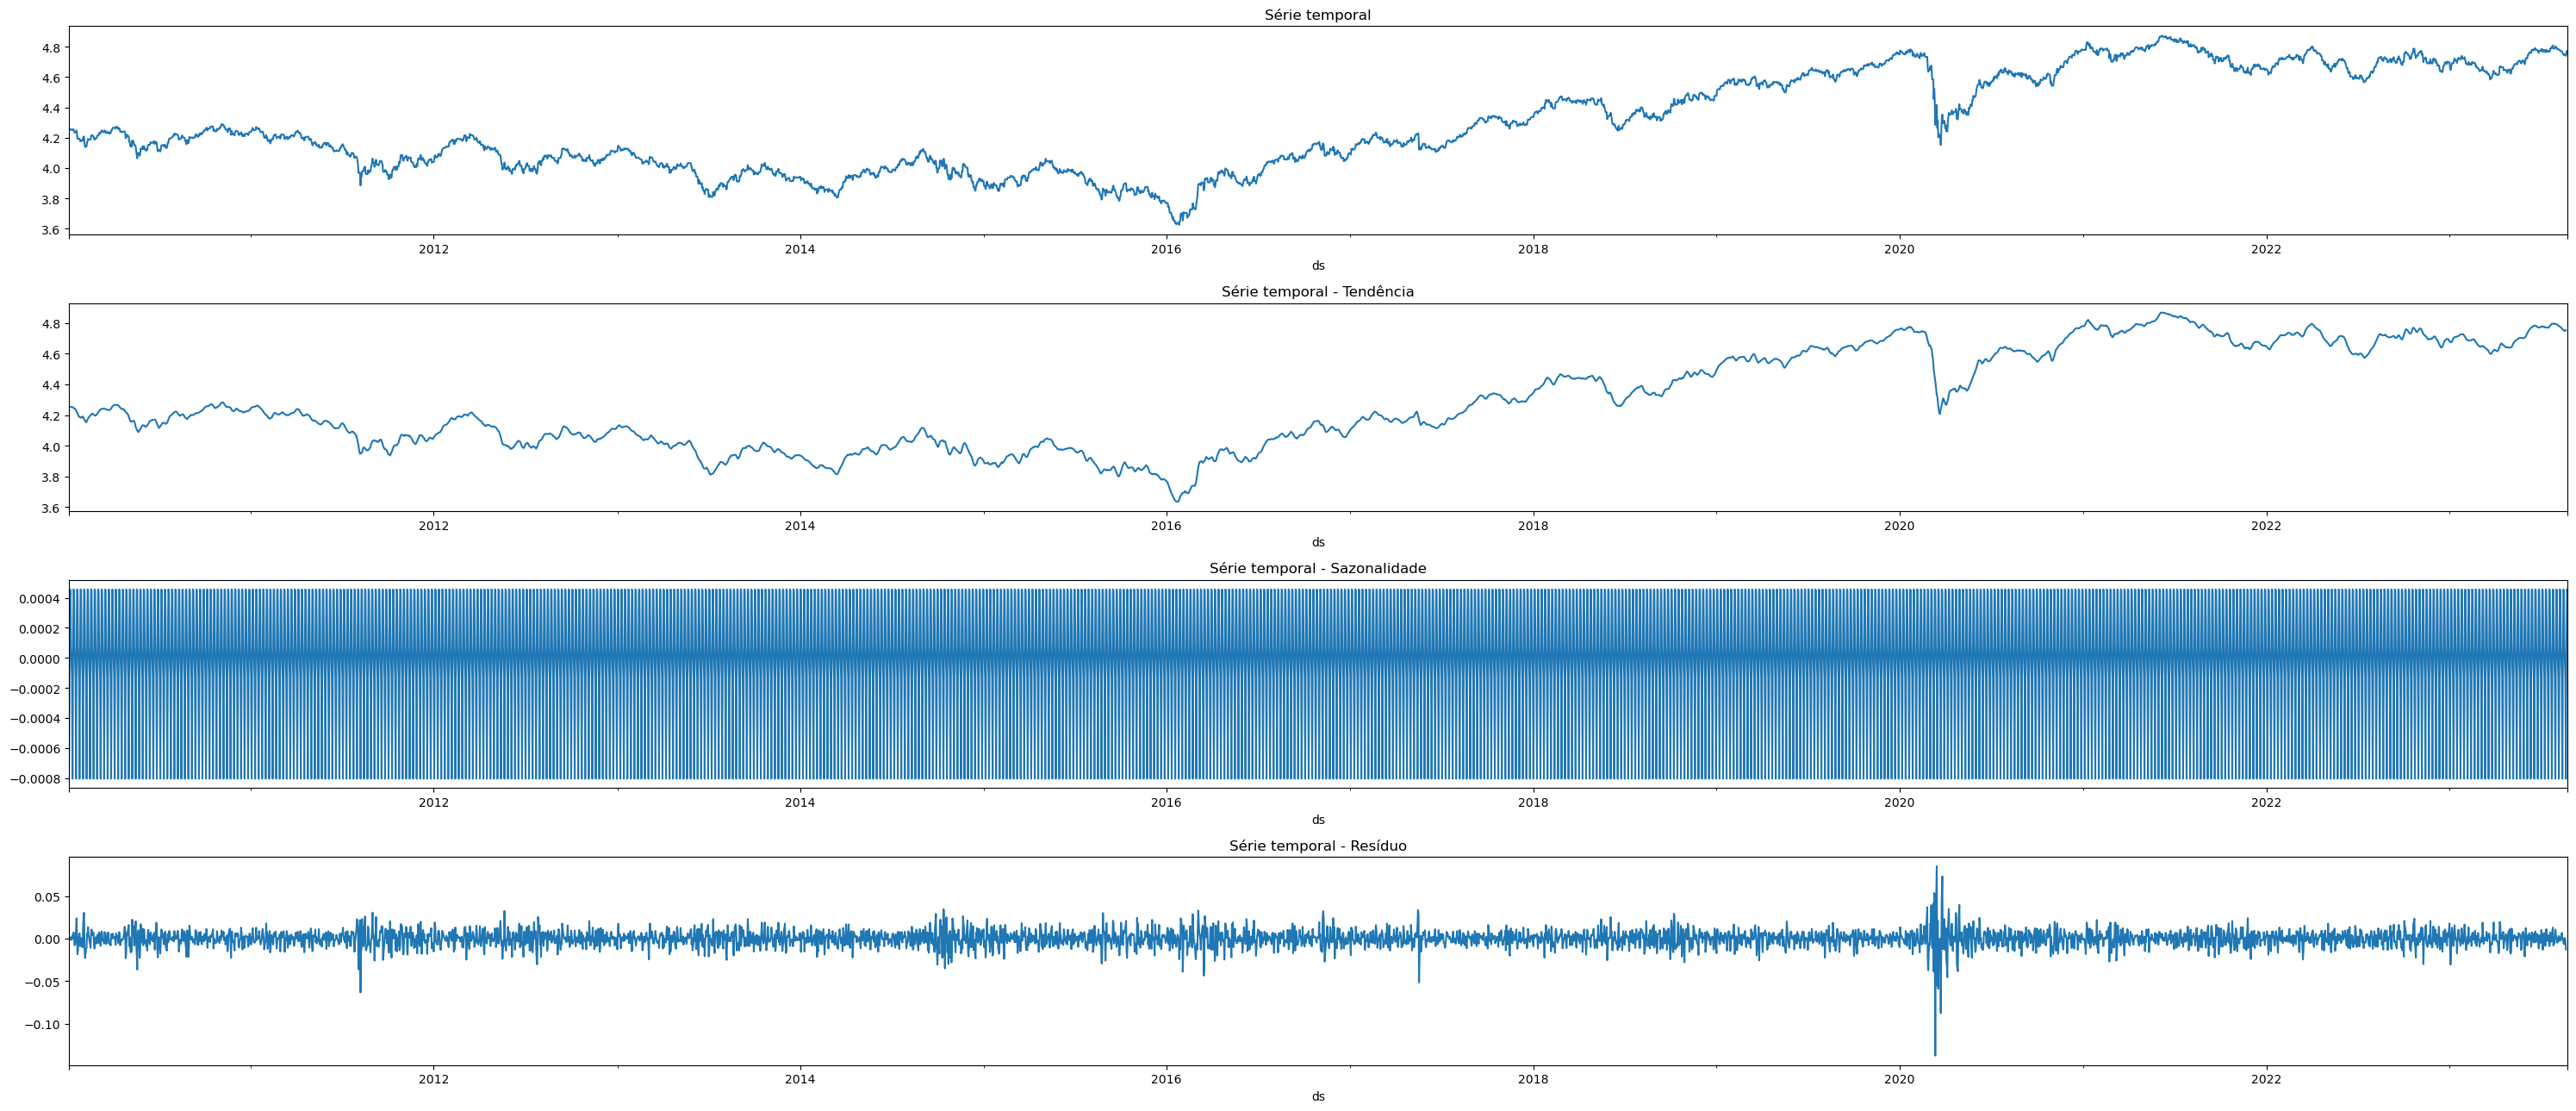

In [41]:
result = seasonal_decompose(dados_log)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.set_title('Série temporal')
ax2.set_title('Série temporal - Tendência')
ax3.set_title('Série temporal - Sazonalidade')
ax4.set_title('Série temporal - Resíduo')

plt.tight_layout()

## Teste ADF

In [42]:
result_adfuller = adfuller(dados_log.y)

print('Teste ADF')

print(f'Teste estatístico: {result_adfuller[0]}')
print(f'P-value: {result_adfuller[1]}')
print('\n')

print('Valores críticos:')
for key,value in result_adfuller[4].items():
    print(f'{key}: {value}')

Teste ADF
Teste estatístico: -1.015328550201414
P-value: 0.7476325896137215


Valores críticos:
1%: -3.4316669649844727
5%: -2.8621219552891963
10%: -2.5670797756478825


Portanto, aplicando a transformada logarítmica não ocorreram mudanças significativas na série temporal.

# Diferença entre série temporal logarítmica e média móvel

## Média móvel

In [43]:
dados_log_subt = dados_log - ma_log
ma_subt = dados_log_subt.rolling(12).mean()
std_subt = dados_log.rolling(12).std()
dados_log_subt.dropna(inplace=True)

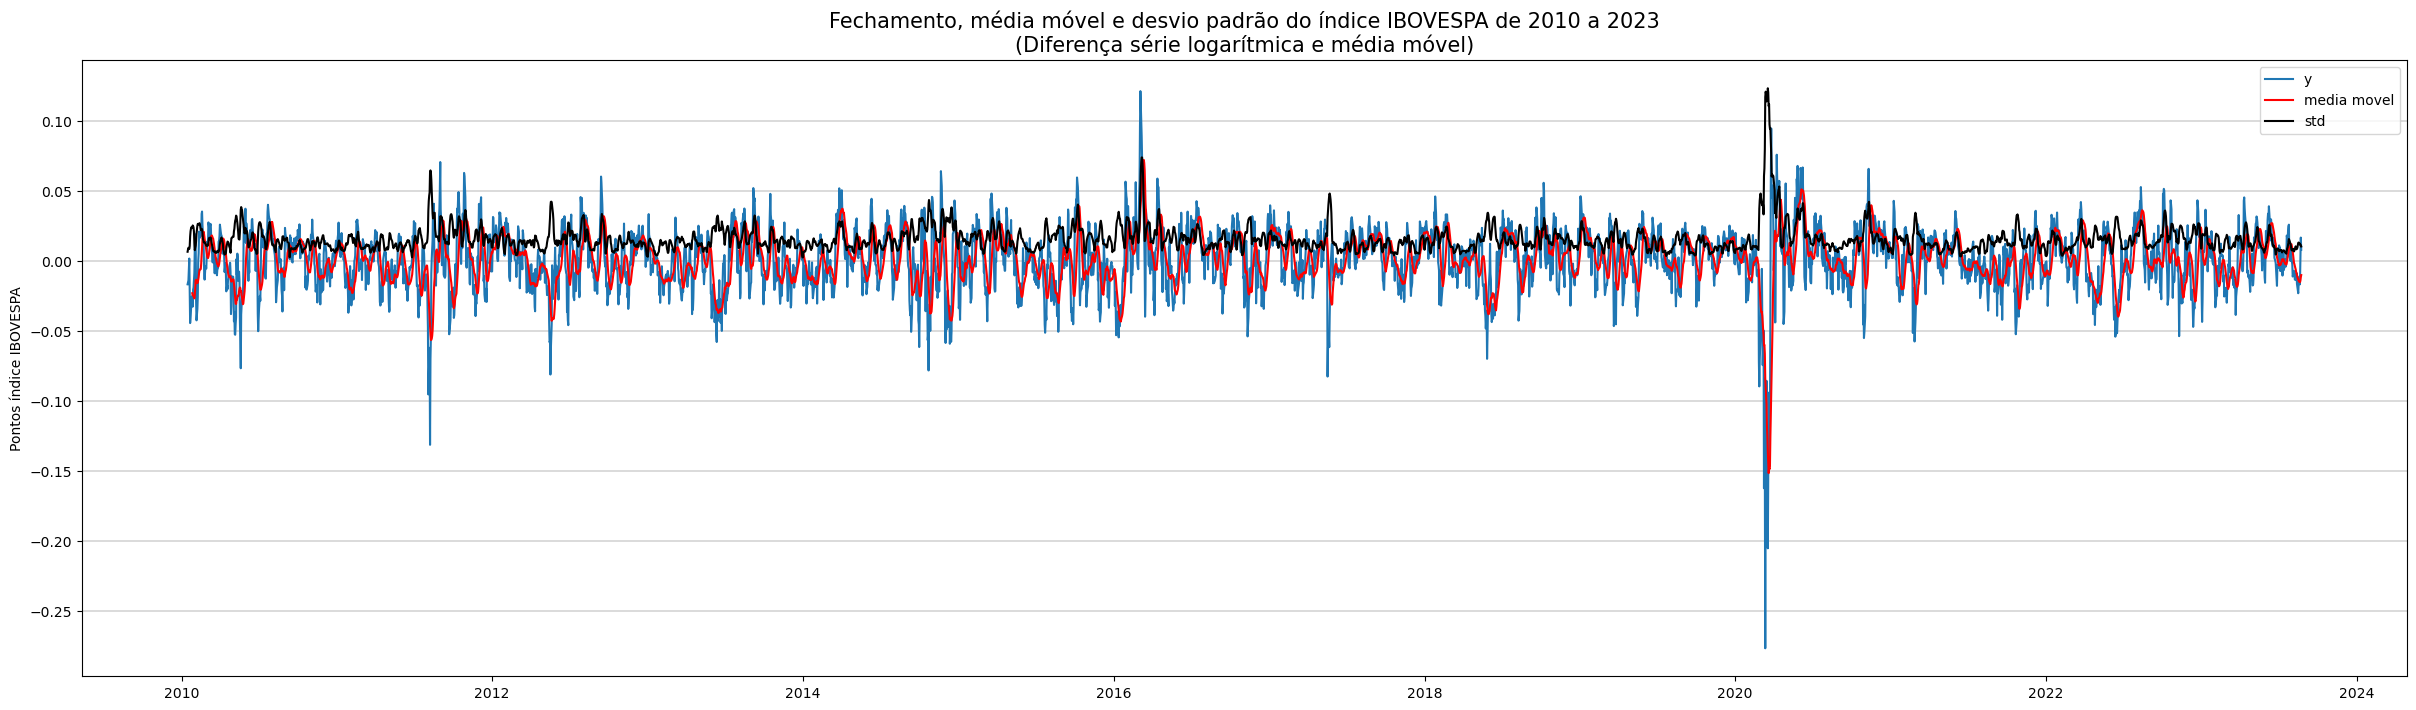

In [44]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados_log_subt, x='ds', y='y', ax=ax, label='y')
sns.lineplot(ma_subt, x='ds', y='y', ax=ax, color='r', label='media movel')
sns.lineplot(std_subt, x='ds', y='y', ax=ax, color='black', label='std')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('Fechamento, média móvel e desvio padrão do índice IBOVESPA de 2010 a 2023\n(Diferença série logarítmica e média móvel)', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

## Componentes da série

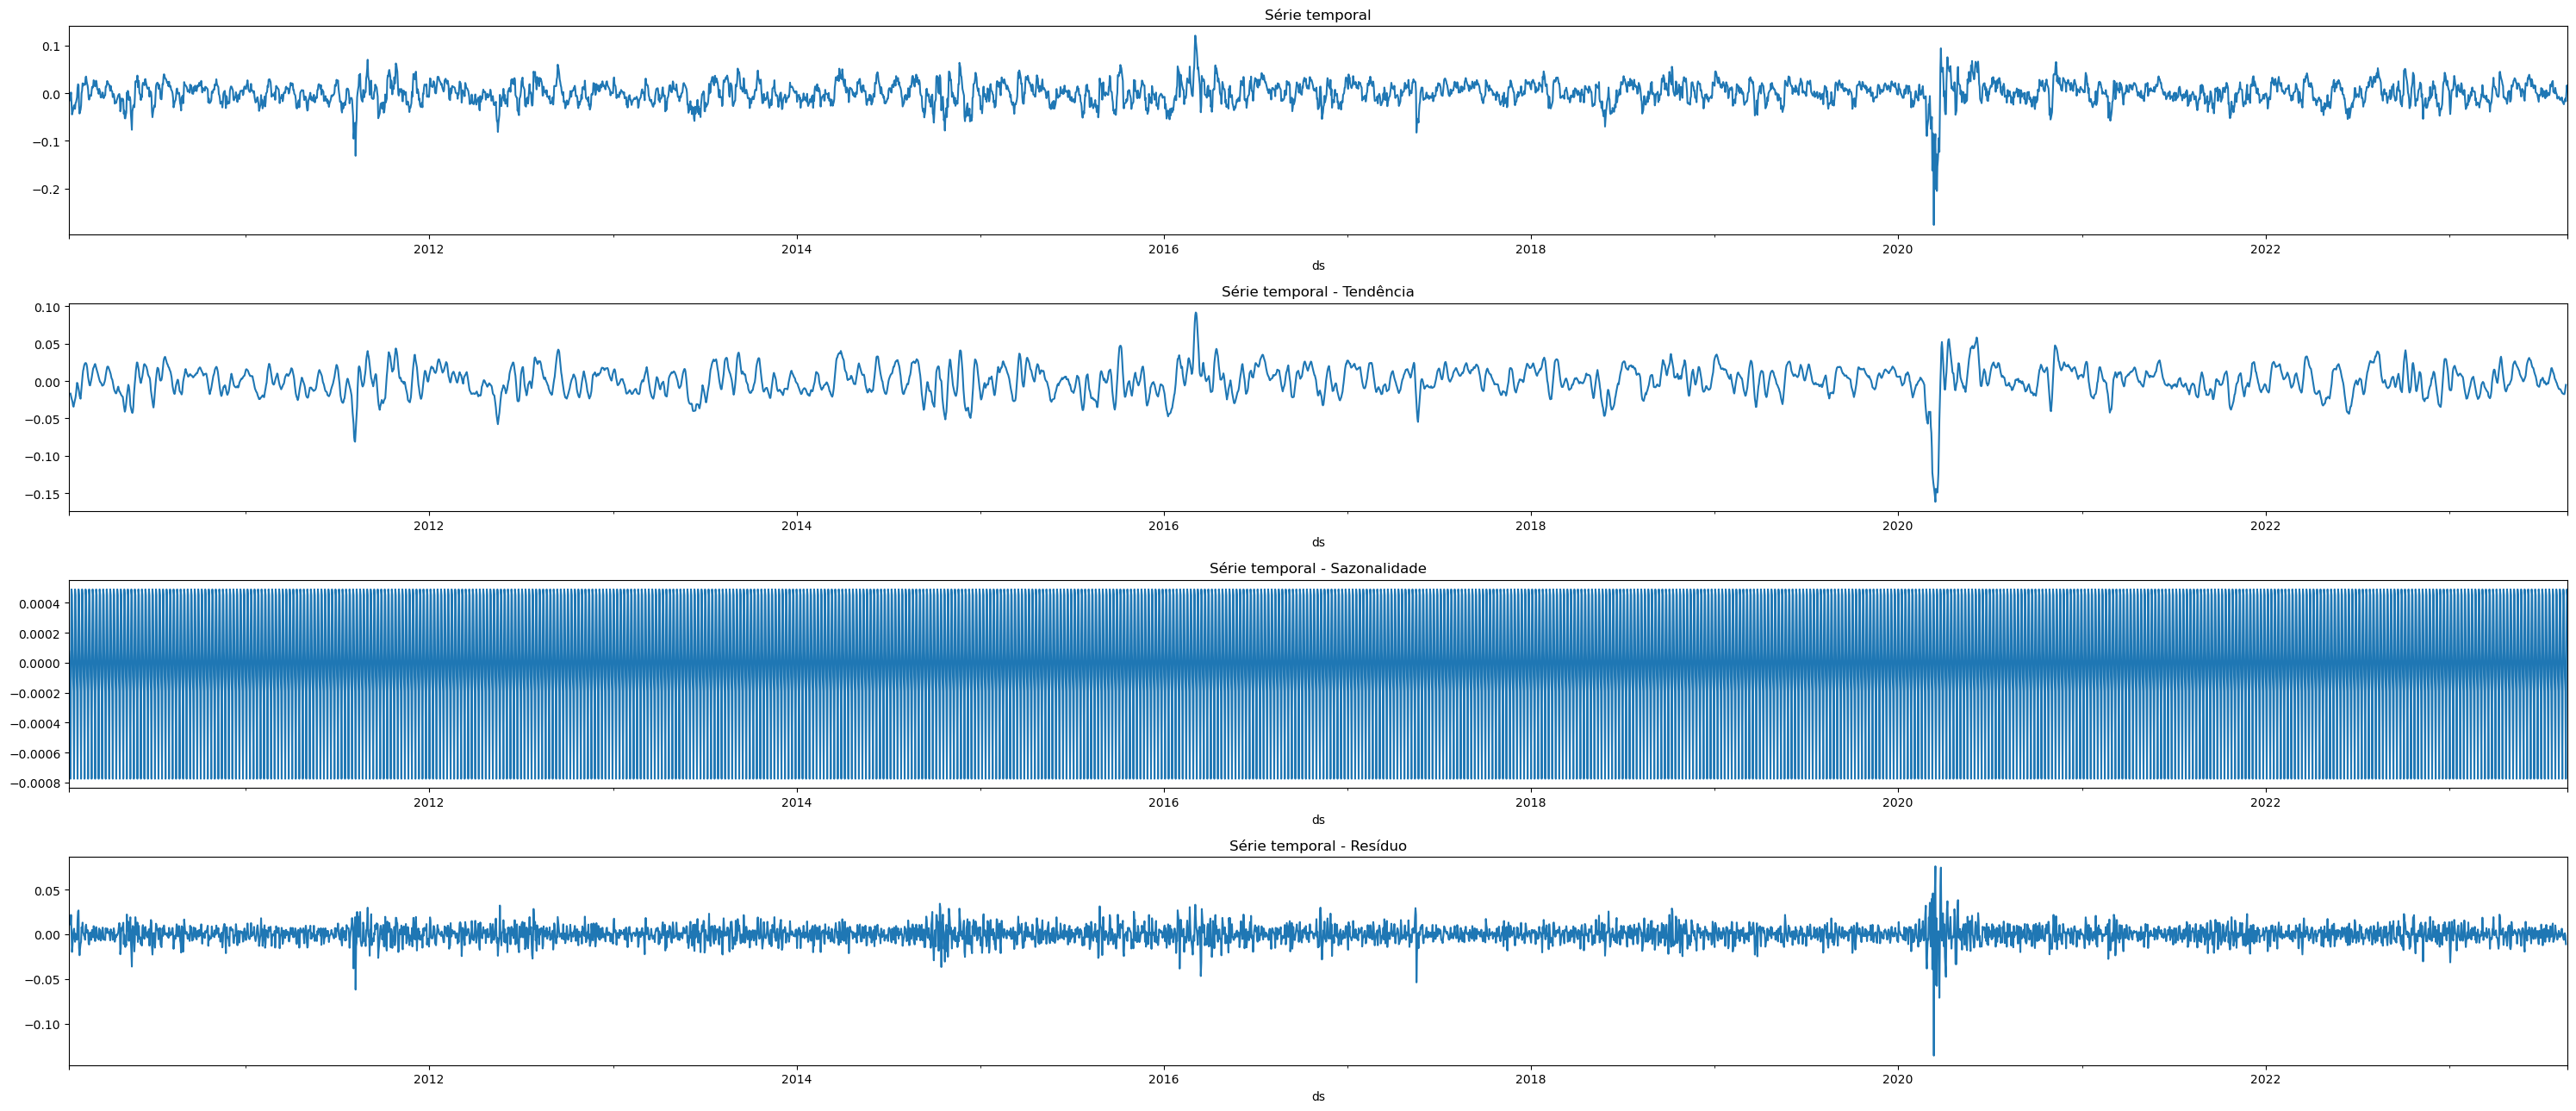

In [45]:
result = seasonal_decompose(dados_log_subt)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.set_title('Série temporal')
ax2.set_title('Série temporal - Tendência')
ax3.set_title('Série temporal - Sazonalidade')
ax4.set_title('Série temporal - Resíduo')

plt.tight_layout()

## Teste ADF

In [46]:
result_adfuller = adfuller(dados_log_subt.y)

print('Teste ADF')

print(f'Teste estatístico: {result_adfuller[0]}')
print(f'P-value: {result_adfuller[1]}')
print('\n')

print('Valores críticos:')
for key,value in result_adfuller[4].items():
    print(f'{key}: {value}')

if(result_adfuller[1] < result_adfuller[4]['5%']):
    print('H0 nula confirmada, não é estacionária')
else:
    print('H1 alternativa confirmada, é estacionária')

Teste ADF
Teste estatístico: -14.734478957402642
P-value: 2.6285362454066422e-27


Valores críticos:
1%: -3.4316698889560326
5%: -2.8621232470799196
10%: -2.5670804633192237
H1 alternativa confirmada, é estacionária


Desta vez, a diferença entre a série em escala logarítmica e a média móvel resultou em uma série temporal mais constante, visualmente com caráter estacionário.

Tal hipótese foi confirmada com o teste ADF que indicou uma série temporal estacionária.

# Série temporal derivada

## Média móvel

In [47]:
dados_diff = dados_log_subt.diff(1)
ma_diff = dados_diff.rolling(12).mean()
std_diff = dados_diff.rolling(12).std()
dados_diff.dropna(inplace=True)

dados_diff

y
ds                  
2010-01-16  0.001279
2010-01-17  0.001511
2010-01-18  0.007693
2010-01-19  0.007937
2010-01-20 -0.022266
...              ...
2023-08-20  0.002616
2023-08-21 -0.005679
2023-08-22  0.016539
2023-08-23  0.016845
2023-08-24 -0.008695

[4969 rows x 1 columns]

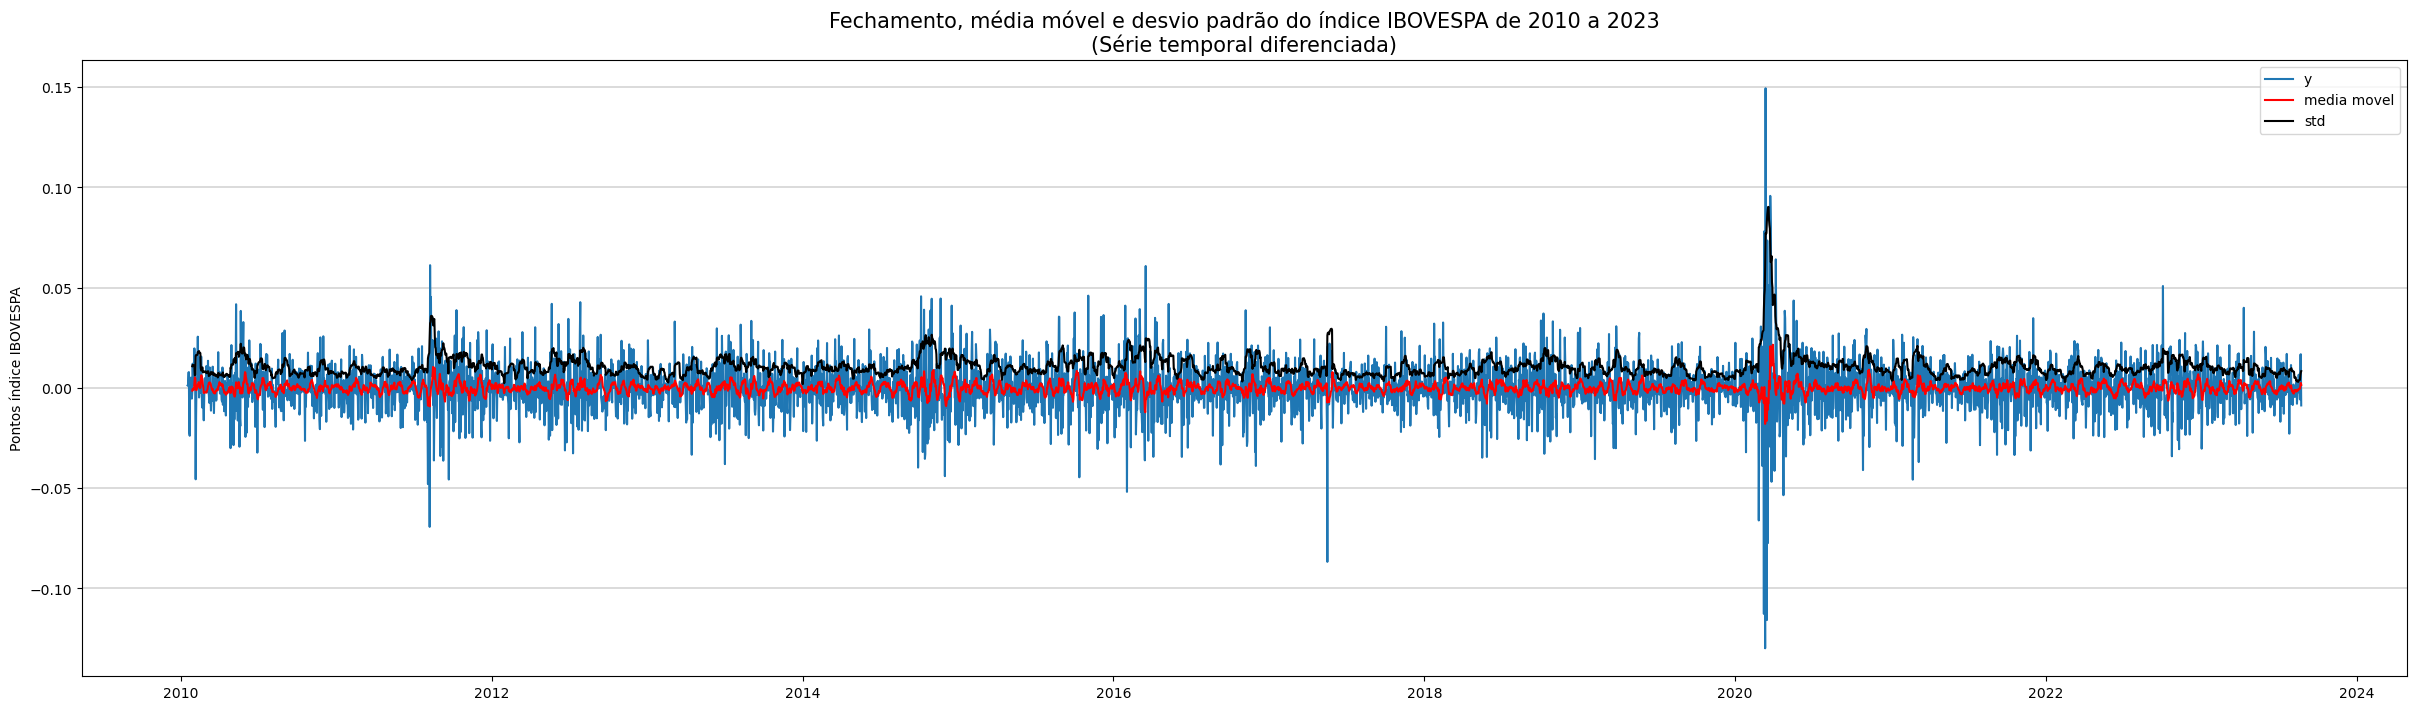

In [48]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados_diff, x='ds', y='y', ax=ax, label='y')
sns.lineplot(ma_diff, x='ds', y='y', ax=ax, color='r', label='media movel')
sns.lineplot(std_diff, x='ds', y='y', ax=ax, color='black', label='std')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('Fechamento, média móvel e desvio padrão do índice IBOVESPA de 2010 a 2023\n(Série temporal diferenciada)', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

## Componentes da série

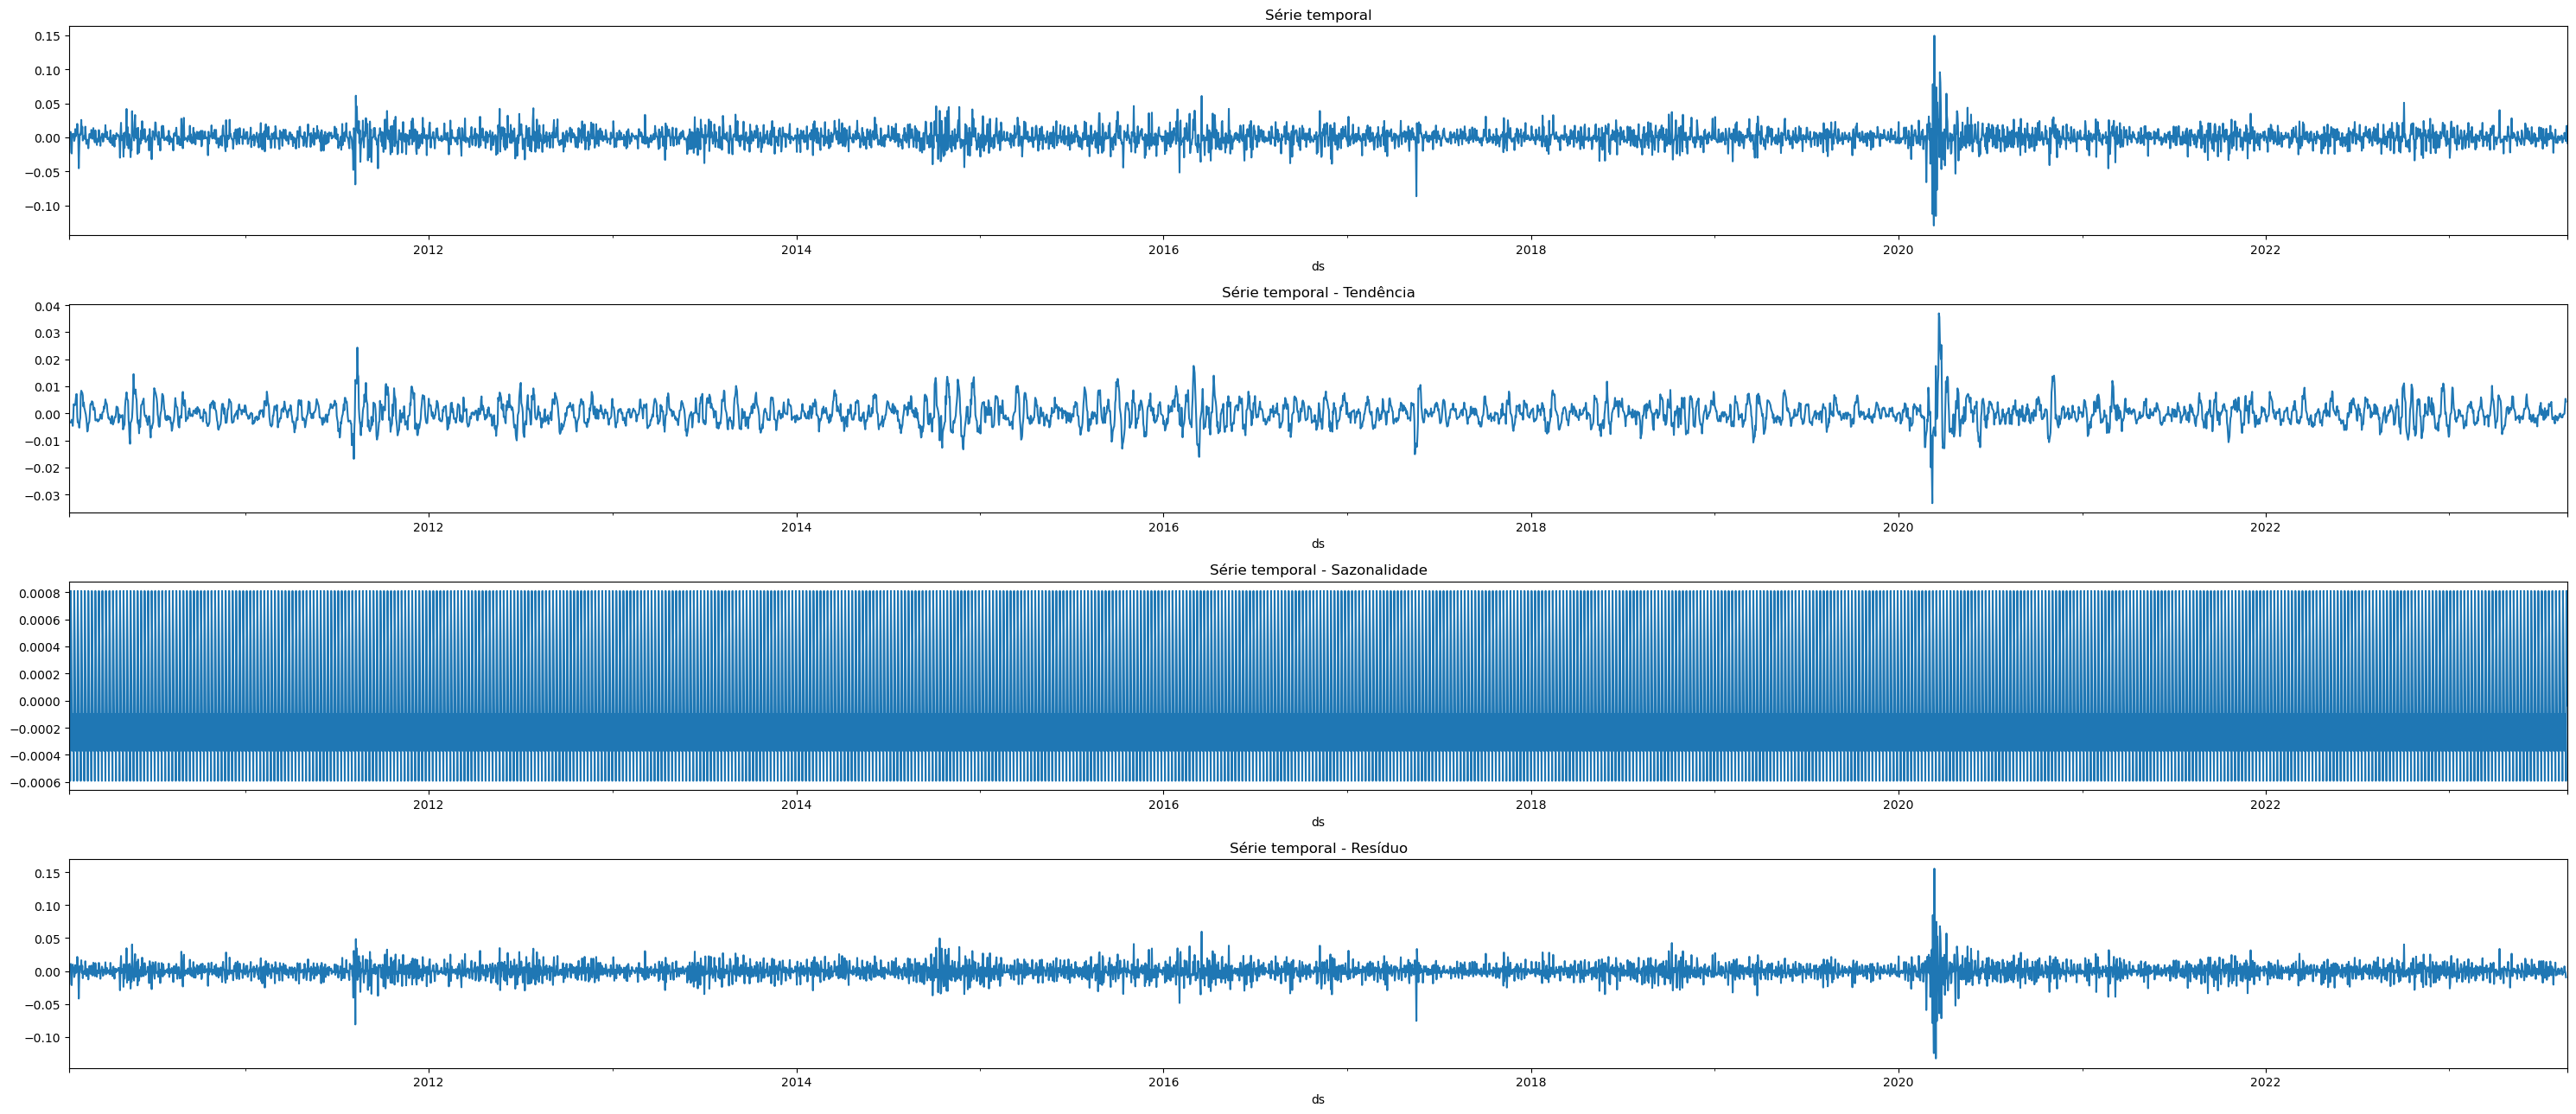

In [49]:
result = seasonal_decompose(dados_diff)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.set_title('Série temporal')
ax2.set_title('Série temporal - Tendência')
ax3.set_title('Série temporal - Sazonalidade')
ax4.set_title('Série temporal - Resíduo')

plt.tight_layout()

## Teste ADF

In [50]:
result_adfuller = adfuller(dados_diff.y)

print('Teste ADF')

print(f'Teste estatístico: {result_adfuller[0]}')
print(f'P-value: {result_adfuller[1]}')
print('\n')

print('Valores críticos:')
for key,value in result_adfuller[4].items():
    print(f'{key}: {value}')

if(result_adfuller[1] < result_adfuller[4]['5%']):
    print('H0 nula confirmada, não é estacionária')
else:
    print('H1 alternativa confirmada, é estacionária')

Teste ADF
Teste estatístico: -19.25879438330104
P-value: 0.0


Valores críticos:
1%: -3.4316755072912444
5%: -2.862125729218594
10%: -2.5670817846605103
H1 alternativa confirmada, é estacionária


Novamente, tem-se uma série temporal visualmente muito mais constante, com aspecto estacionário.

O o teste ADF confirmar a hipótese de série temporal estacionária.

# ACF e PACF

Com as séries temporais estacionárias obtidas a partir da diferenciação da série original, podem ser calculados os valores de ACF (Autocorrelation Function) e PACF (Partial Autocorrelation Function).

Esta análise traz importantes resultados sobre a sazonalidade e a randomicidade da série temporal, bem como indica o grau de correlação entre os próprios intervalos de tempo existentes na série temporal.

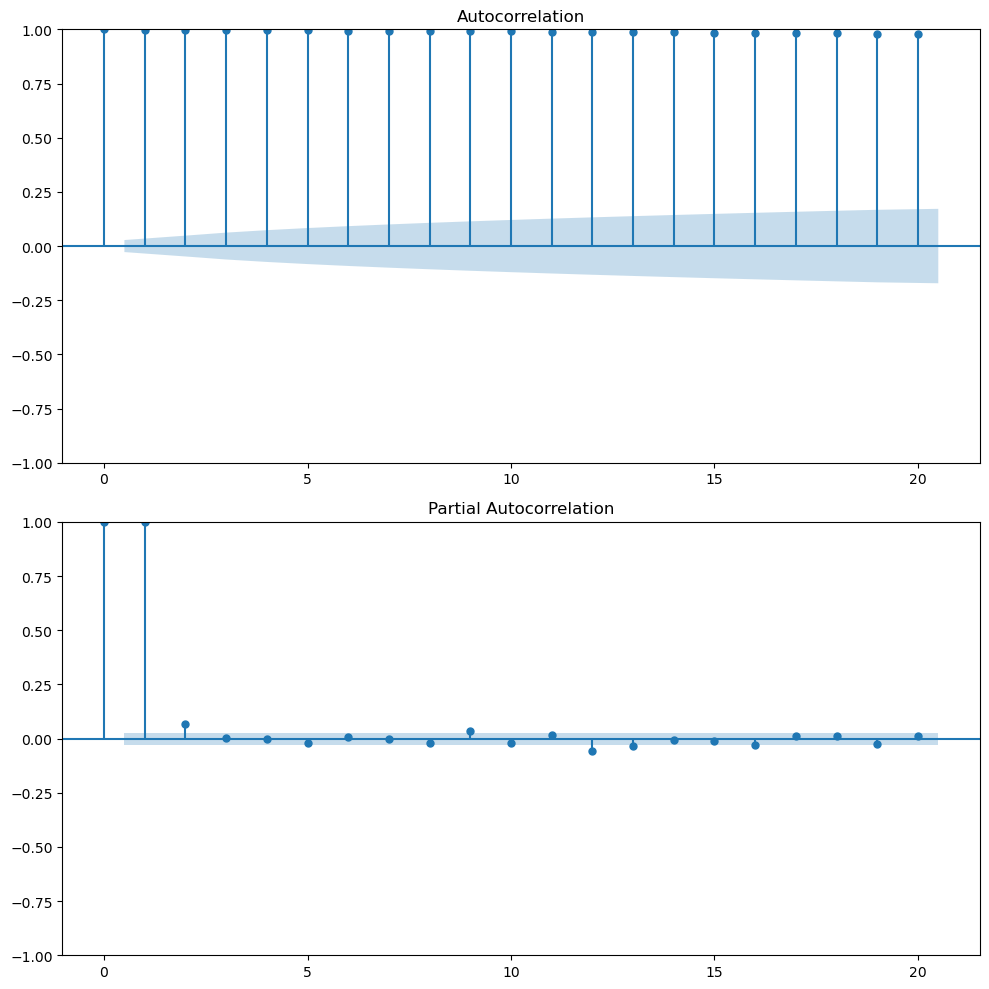

In [70]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

plot_acf(dados_date_index.y, lags=20, ax=ax[0])
plot_pacf(dados_date_index.y, lags=20, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

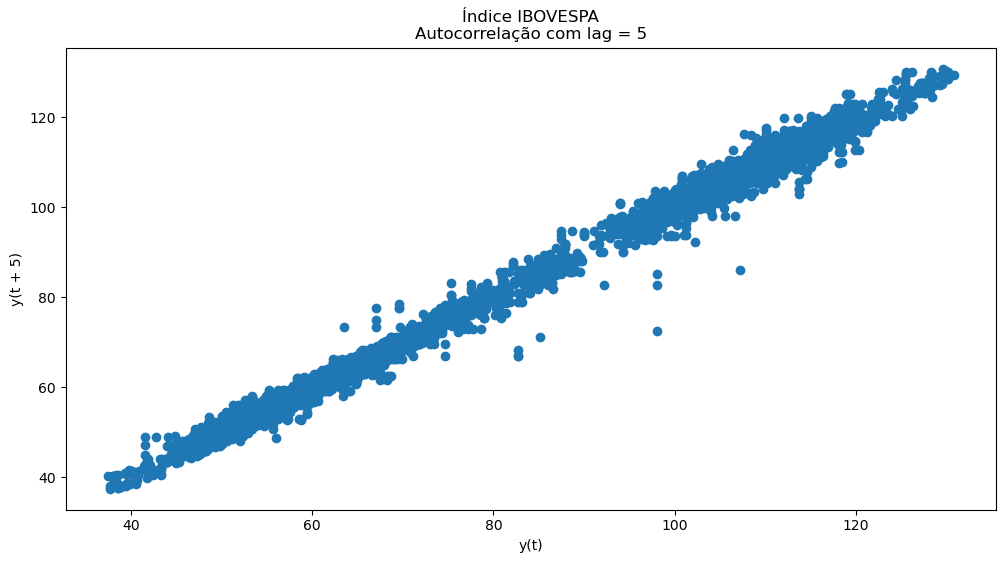

In [71]:
plt.figure(figsize=(12, 6))

lag_plot(dados_date_index.y, lag=5)

plt.title('Índice IBOVESPA\nAutocorrelação com lag = 5')

plt.show()

Com os gráficos, confirma-se a existência de autocorrelação na série temporal, especialmente com lags pequenos, ou seja, em um intervalo de dias reduzido.

É perceptível uma forte autocorrelação na série temporal do IBOVESPA em intervalos de 5 dias (lag = 5), ou seja, analisando um período de 5 dias geralmente serão observados valores do índice muito semelhantes.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

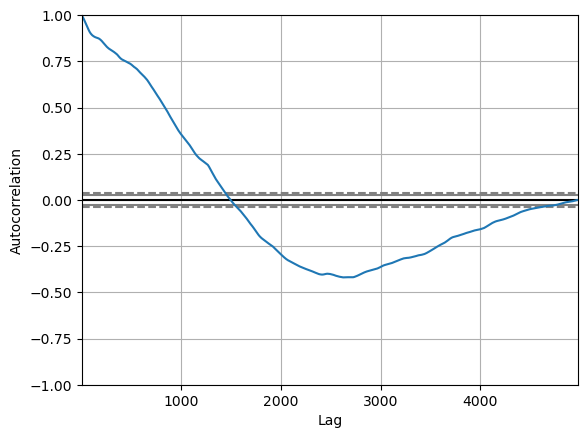

In [53]:
autocorrelation_plot(dados_date_index)

# Datasets de treino e teste

In [54]:
train_set_date_col = dados_date_col.loc[dados_date_col.ds < '2022-01-01']
test_set_date_col = dados_date_col.loc[dados_date_col.ds >= '2022-01-01']
train_set_date_index = dados_date_index.loc[dados_date_index.index < '2022-01-01']
test_set_date_index = dados_date_index.loc[dados_date_index.index >= '2022-01-01']


print(len(train_set_date_col))
print(len(test_set_date_col))

4380
601


# Modelos NAIVE

Modelos NAIVE são relativamente simples e geralmente são usados como primeira alternativa, para se ter uma ideia de baseline de desempenho para os próximos modelos explorados.

Serão utilizados os seguintes modelos:
- Naive
- SeasonalNaive
- WindowAverage
- SeasonalWindowAverage

Com os parâmetros abaixo:
- h = 601 (período previsto em dias)
- season_length = 7 (período considerado para cálculos de média móvel)
- window_size = 2 (número de seasons utilizadas na média móvel sazonal)

In [55]:
h = len(test_set_date_col)
print(h)

601


In [56]:
model = StatsForecast(models=[Naive(),
                            SeasonalNaive(season_length=7),
                            WindowAverage(window_size=7),
                            SeasonalWindowAverage(window_size=3, season_length=7)],
                            freq='D', n_jobs=-1)


model.fit(train_set_date_col)

StatsForecast(models=[Naive,SeasonalNaive,WindowAverage,SeasWA])

In [57]:
forecast_df = model.predict(h=h+1, level=[90])
forecast_df = forecast_df.reset_index().merge(test_set_date_col, on=['ds','unique_id'], how='left')
forecast_df.dropna(inplace=True)
forecast_df.reset_index(drop=True)

forecast_df

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


unique_id         ds       Naive  Naive-lo-90  Naive-hi-90  SeasonalNaive  \
0    ibovespa 2022-01-01  104.821999   103.257133   106.386864     104.890999   
1    ibovespa 2022-01-02  104.821999   102.608948   107.035049     104.890999   
2    ibovespa 2022-01-03  104.821999   102.111572   107.532425     105.554001   
3    ibovespa 2022-01-04  104.821999   101.692268   107.951729     104.863998   
4    ibovespa 2022-01-05  104.821999   101.322853   108.321144     104.107002   
..        ...        ...         ...          ...          ...            ...   
596  ibovespa 2023-08-20  104.821999    66.586723   143.057281     104.890999   
597  ibovespa 2023-08-21  104.821999    66.554710   143.089279     105.554001   
598  ibovespa 2023-08-22  104.821999    66.522728   143.121262     104.863998   
599  ibovespa 2023-08-23  104.821999    66.490776   143.153229     104.107002   
600  ibovespa 2023-08-24  104.821999    66.458847   143.185150     104.821999   

     SeasonalNaive-lo-90  SeasonalNaive-hi-90  WindowAverage      SeasWA  \
0              69.046326           140.735672     104.850151  106.616669   
1              69.046326           140.735672     104.850151  106.616669   
2              69.709328           141.398682     104.850151  105.985672   
3              69.019325           140.708679     104.850151  105.708000   
4              68.262329           139.951675     104.850151  105.594002   
..                   ...                  ...            ...         ...   
596            69.046326           140.735672     104.850151  106.616669   
597            69.709328           141.398682     104.850151  105.985672   
598            69.019325           140.708679     104.850151  105.708000   
599            68.262329           139.951675     104.850151  105.594002   
600            68.977325           140.666672     104.850151  106.013000   

           y  
0    104.822  
1    104.822  
2    103.922  
3    103.514  
4    101.006  
..       ...  
596  115.409  
597  114.429  
598  116.156  
599  118.135  
600  117.026  

[601 rows x 11 columns]

Naive WMAPE: 6.11%
Naive Test RMSE: 7.99
Naive MAE: 6.73


SeasonalNaive WMAPE: 6.10%
SeasonalNaive Test RMSE: 7.99
SeasonalNaive MAE: 6.72


WindowAverage WMAPE: 6.10%
WindowAverage Test RMSE: 7.98
WindowAverage MAE: 6.72


SeasWA WMAPE: 5.54%
SeasWA Test RMSE: 7.26
SeasWA MAE: 6.10




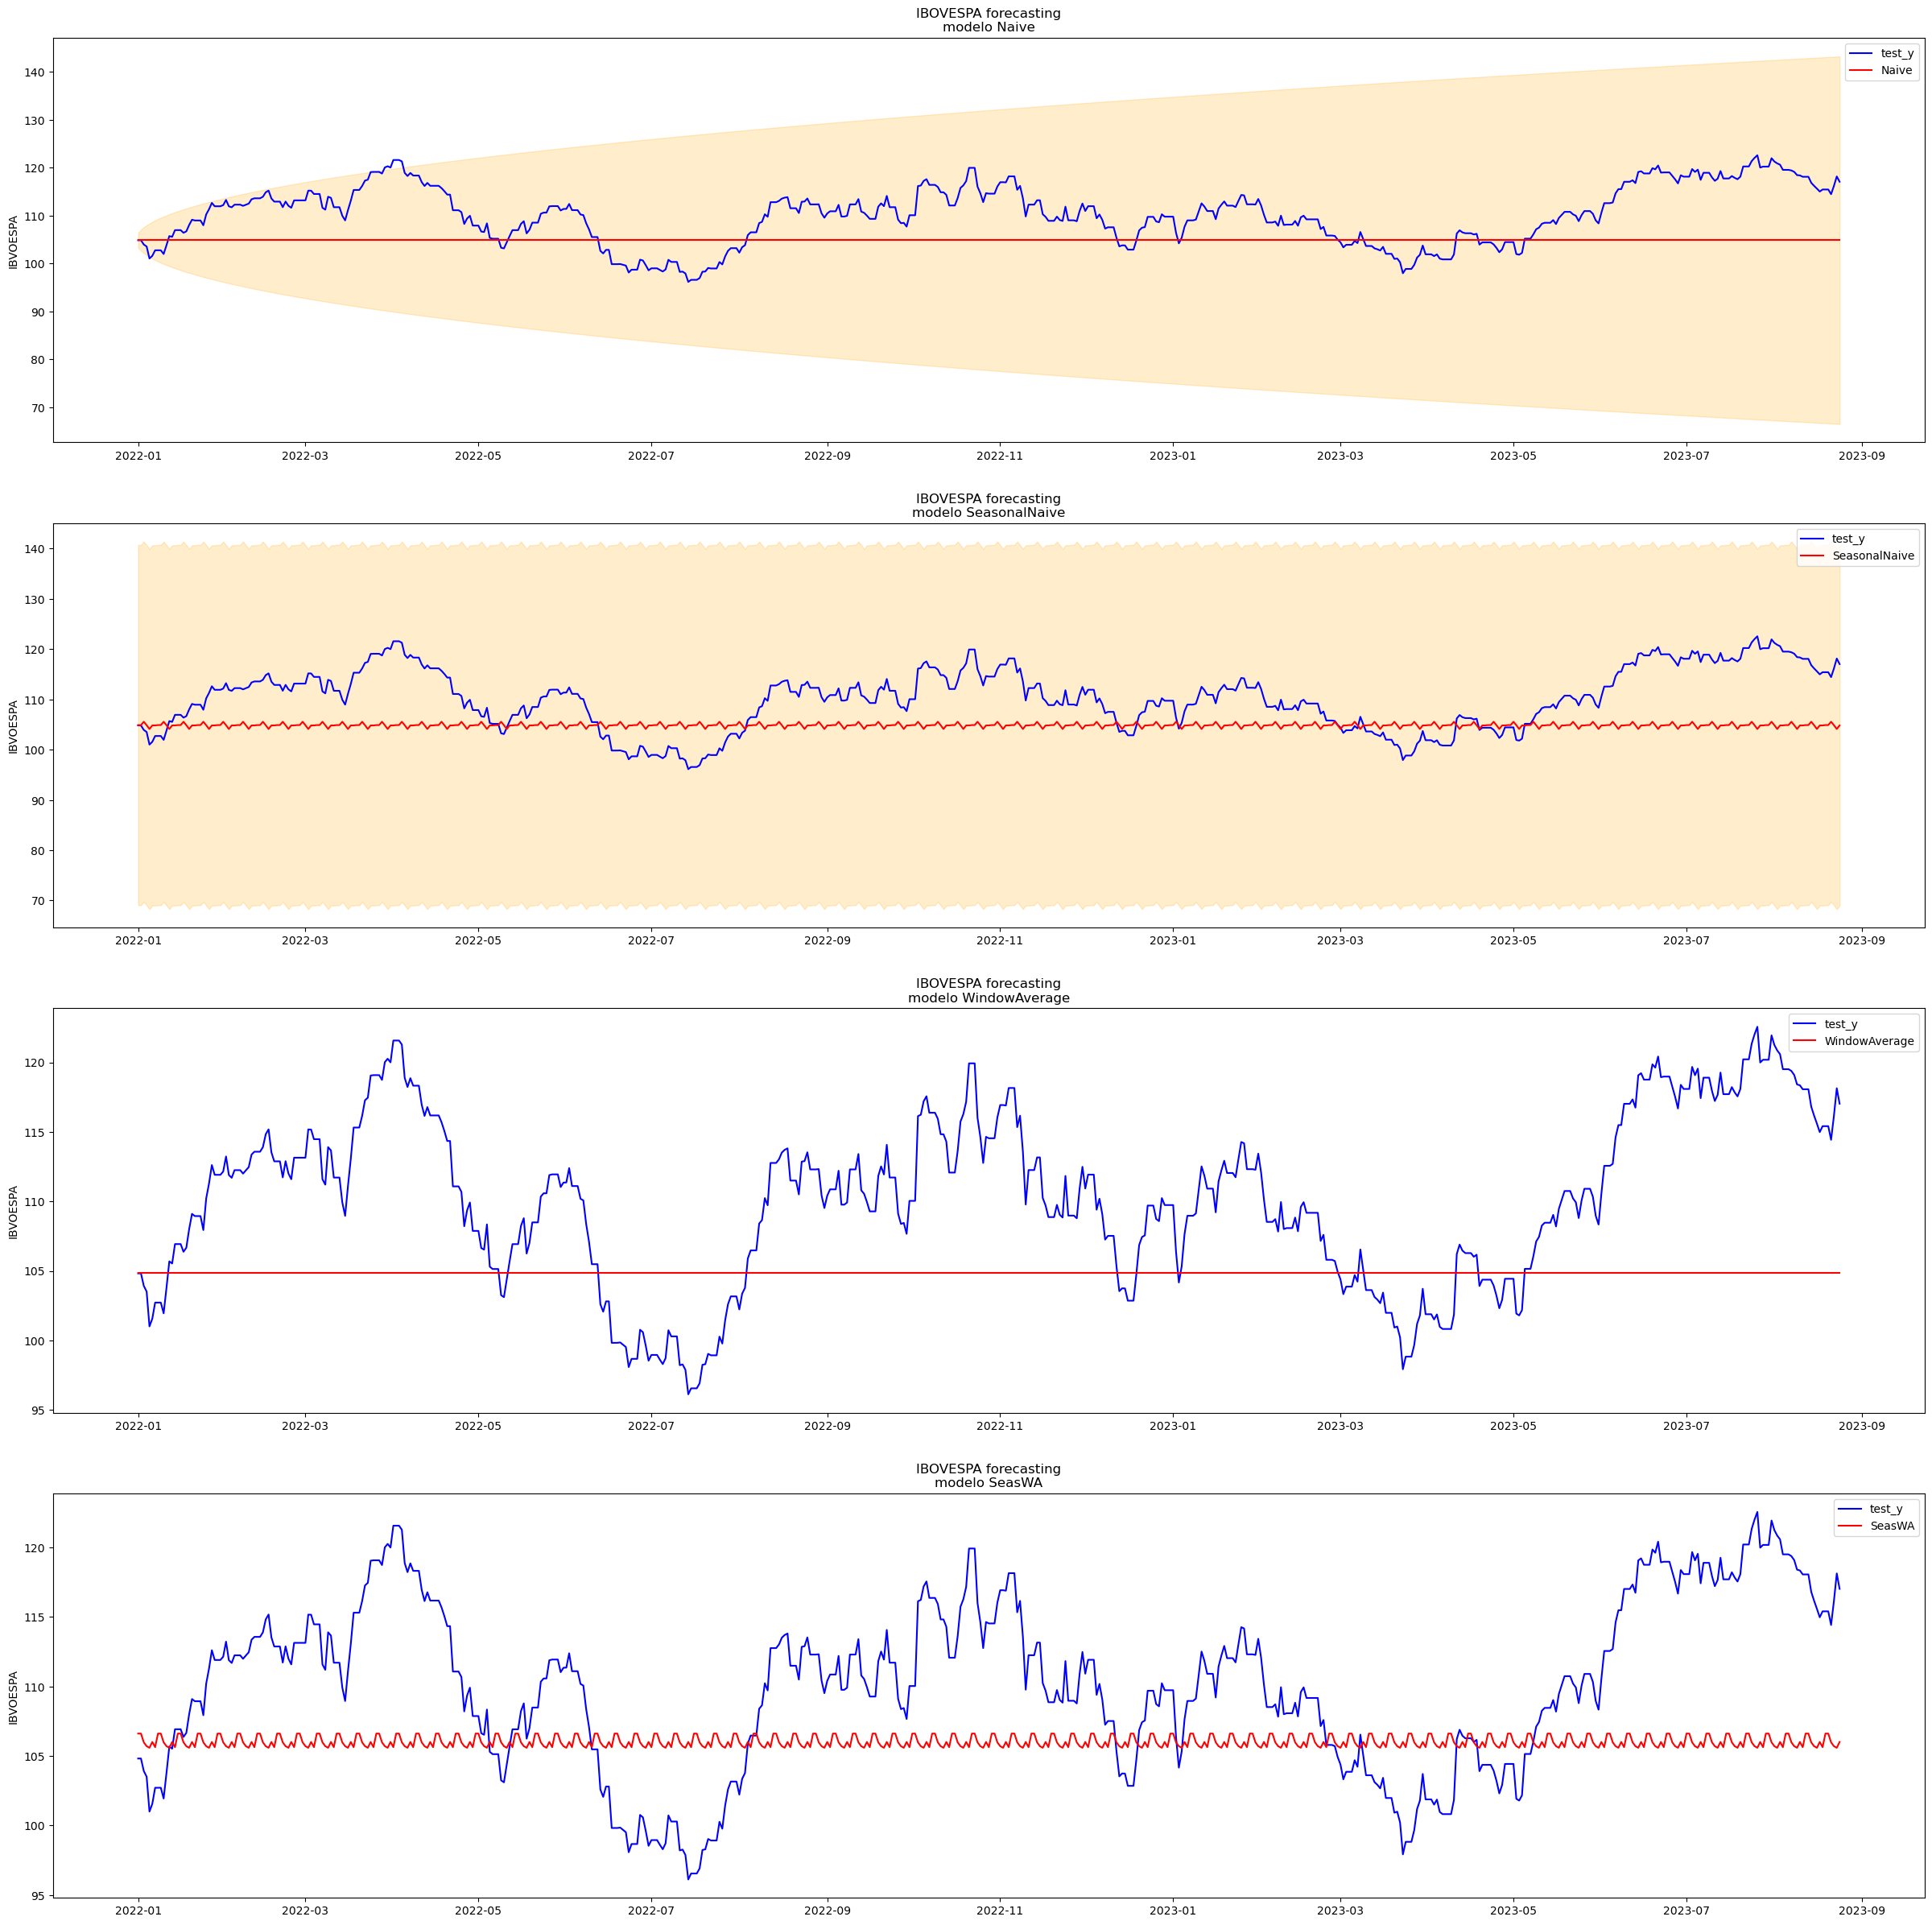

In [58]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(30, 30))

list_models = ['Naive', 'SeasonalNaive', 'WindowAverage', 'SeasWA']

for model_ in list_models:
    i = list_models.index(model_)

    sns.lineplot(forecast_df, x='ds', y='y', ax=ax[i], color='blue', label='test_y')
    sns.lineplot(forecast_df, x='ds', y=model_, ax=ax[i], color='red', label=model_)

    ax[i].set_xlabel('')
    ax[i].set_ylabel('IBVOESPA')

    ax[i].set_title(f'IBOVESPA forecasting\nmodelo {model_}')

    if model_ in ['Naive', 'SeasonalNaive']:
        ax[i].fill_between(forecast_df.ds.values, forecast_df[f'{model_}-lo-90'], forecast_df[f'{model_}-hi-90'], alpha=0.2, color='orange')

    wmape_ = calc_wmape(forecast_df.y.values, forecast_df[f'{model_}'].values)
    rmse_ = sqrt(mean_squared_error(forecast_df.y.values, forecast_df[f'{model_}'].values))
    mae_ = calc_mae(forecast_df.y.values, forecast_df[f'{model_}'].values)

    print(f'{model_} WMAPE: {wmape_:.2%}')
    print(f'{model_} Test RMSE: %.2f' % rmse_)
    print(f'{model_} MAE: %.2f' % mae_)
    print('\n')




Como esperado, os diferentes modelos Naive não atenderam à demanda do problema que lida com uma série temporal muito caótica, sem sazonalidade ou padrão algum.

Por esse motivo, mesmo os erros terem sido relativamente baixos, claramente as curvas previstas não condizem com a realidade do índice IBOVESPA, os modelos tiveram desempenho muito abaixo do ideal.

Em seguida, serão testados modelos mais complexos, como o ARIMA.

# Modelo ARIMA

**Parâmetros:**
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

## Modelo ARIMA padrão

Será usado um lag de 5 dias no parãmetro p, tendo em vista que há forte autocorrelação nesse intervalo na série temporal.

In [59]:
arima_model = ARIMA(train_set_date_index, order=(5,1,0))

In [60]:
arima_model_fit = arima_model.fit()

In [61]:
y_pred = arima_model_fit.forecast(len(test_set_date_index))

In [62]:
residuals = pd.DataFrame(arima_model_fit.resid)

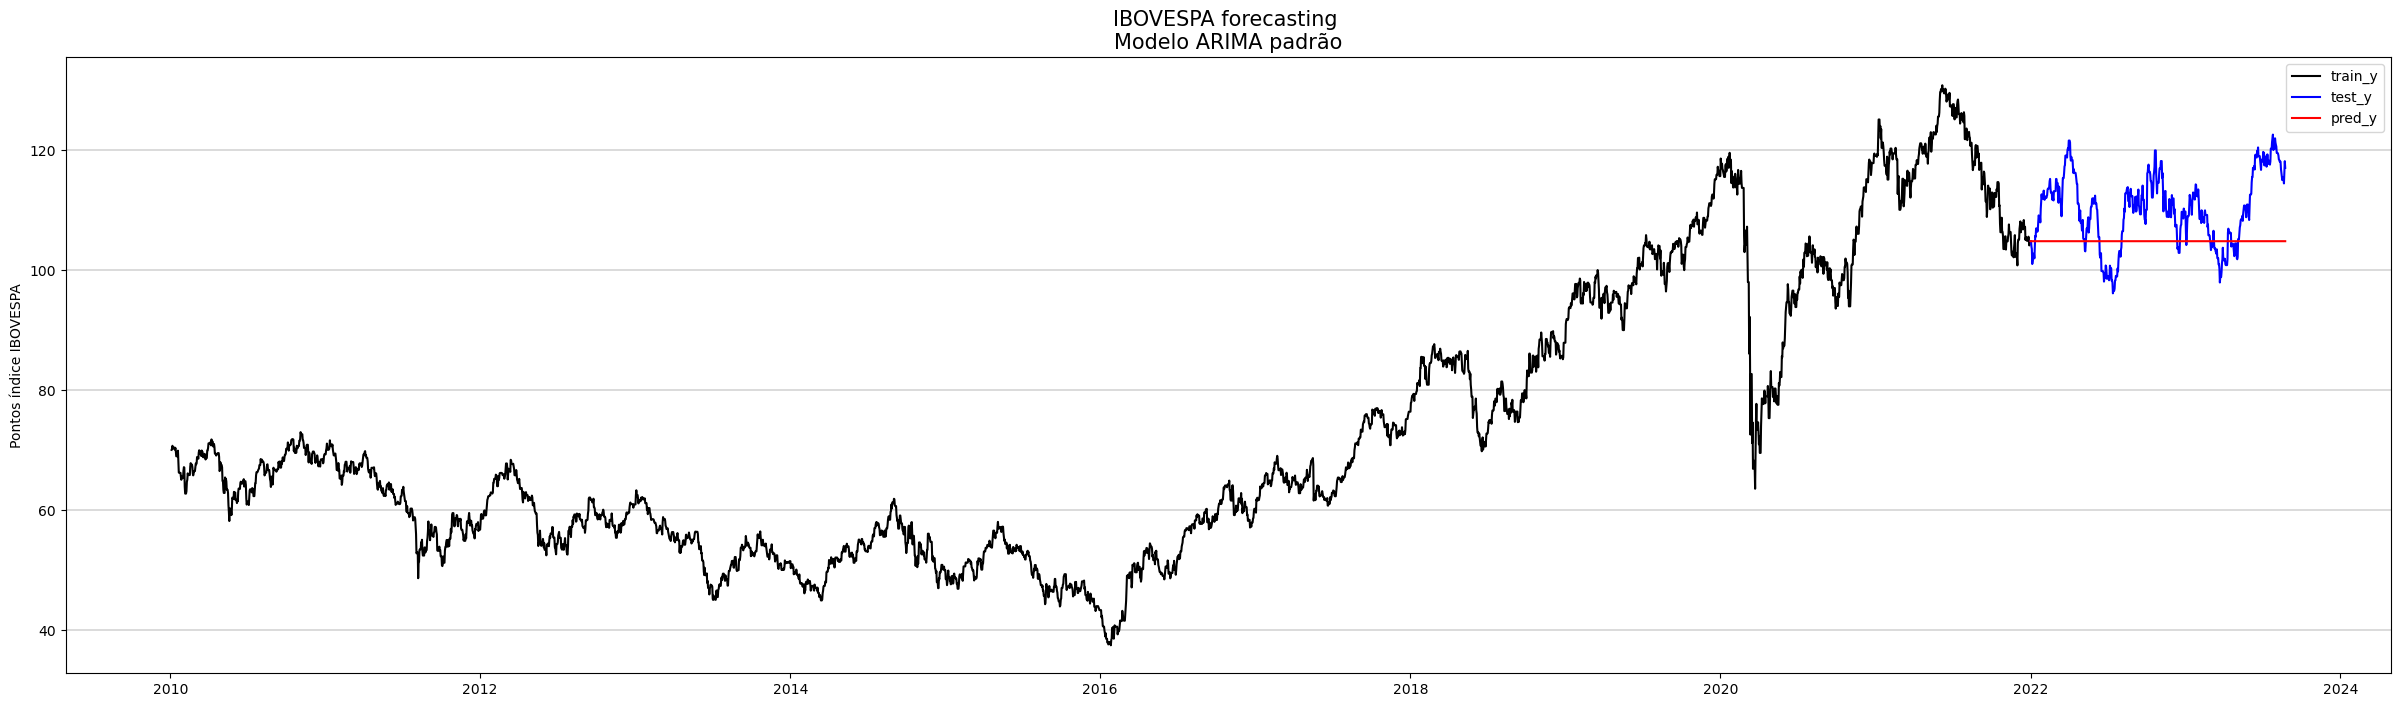

ARIMA padrão WMAPE: 6.12%
ARIMA padrão Test RMSE: 8.01
ARIMA padrão MAE: 6.74


In [77]:
model_ = 'ARIMA padrão'

fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(train_set_date_index, x='ds', y='y', ax=ax, label='train_y', color='black')
sns.lineplot(test_set_date_index, x='ds', y='y', ax=ax, color='blue', label='test_y')
sns.lineplot(y_pred, ax=ax, color='red', label='pred_y')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('IBOVESPA forecasting \nModelo ARIMA padrão', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

wmape_ = calc_wmape(test_set_date_index.y.values, y_pred.values)
rmse_ = sqrt(mean_squared_error(test_set_date_index.y.values, y_pred.values))
mae_ = calc_mae(test_set_date_index.y.values, y_pred.values)

print(f'{model_} WMAPE: {wmape_:.2%}')
print(f'{model_} Test RMSE: %.2f' % rmse_)
print(f'{model_} MAE: %.2f' % mae_)

In [65]:
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4380
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5978.138
Date:                Sat, 02 Sep 2023   AIC                          11968.276
Time:                        11:35:36   BIC                          12006.584
Sample:                    01-04-2010   HQIC                         11981.793
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0843      0.006    -13.883      0.000      -0.096      -0.072
ar.L2         -0.0032      0.007     -0.490      0.624      -0.016       0.010
ar.L3         -0.0076      0.007     -1.067      0.2

Apesar do valor baixo no WMAPE, analisando a curva é visível que o modelo não performou bem, pois foi prevista uma linha constante, muito distante do comportamento da série temporal que possui diversos altos e baixos.

Uma das hipóteses é que o modelo está utilizando o comportamente do dataset de treino para fazer todas as previsões do dataset de teste, quando, na verdade, a cada nova previsão o modelo deveria passar por um novo ajuste de acordo com o valor previsto.

## Modelo ARIMA "retroalimentado"

Para isso, será aplicada a lógica de um laço de repetiçao, em que a cada execução uma nova previsão é realizada e um novo ajuste é feito no modelo ARIMA.

Dessa forma, a cada nova previsão será usado um novo conjunto de treino para o modelo, dando mais dinamicidade à previsão da curva.

In [66]:
import warnings
warnings.filterwarnings("ignore")

In [85]:
y_pred_step = []
history = train_set_date_index.copy()

for i in range(len(test_set_date_index)):
    model_arima = ARIMA(history, order=(5,1,0))
    model_arima_fit = model_arima.fit()

    output = model_arima_fit.forecast(disp=0)
    yhat = output[0]
    y_pred_step.append(yhat)

    obs = test_set_date_index.values[i]

    history = pd.concat([history, pd.DataFrame({'y':obs}, index=[test_set_date_index.index[i]])])

    print('predicted=%f, expected=%f' % (yhat, obs))

y_pred = test_set_date_index.copy()
y_pred.y = y_pred_step

predicted=104.807924, expected=104.822000
predicted=104.799930, expected=104.822000
predicted=104.840243, expected=103.922000
predicted=103.996728, expected=103.514000
predicted=103.551253, expected=101.006000
predicted=101.224236, expected=101.561000
predicted=101.503001, expected=102.719000
predicted=102.631529, expected=102.719000
predicted=102.653290, expected=102.719000
predicted=102.727165, expected=101.945000
predicted=102.035961, expected=103.779000
predicted=103.625862, expected=105.686000
predicted=105.526240, expected=105.530000
predicted=105.502691, expected=106.928000
predicted=106.840988, expected=106.928000
predicted=106.968797, expected=106.928000
predicted=106.913200, expected=106.374000
predicted=106.453021, expected=106.668000
predicted=106.644169, expected=108.013000
predicted=107.904133, expected=109.102000
predicted=108.992184, expected=108.942000
predicted=108.948511, expected=108.942000
predicted=108.965655, expected=108.942000
predicted=108.968493, expected=107

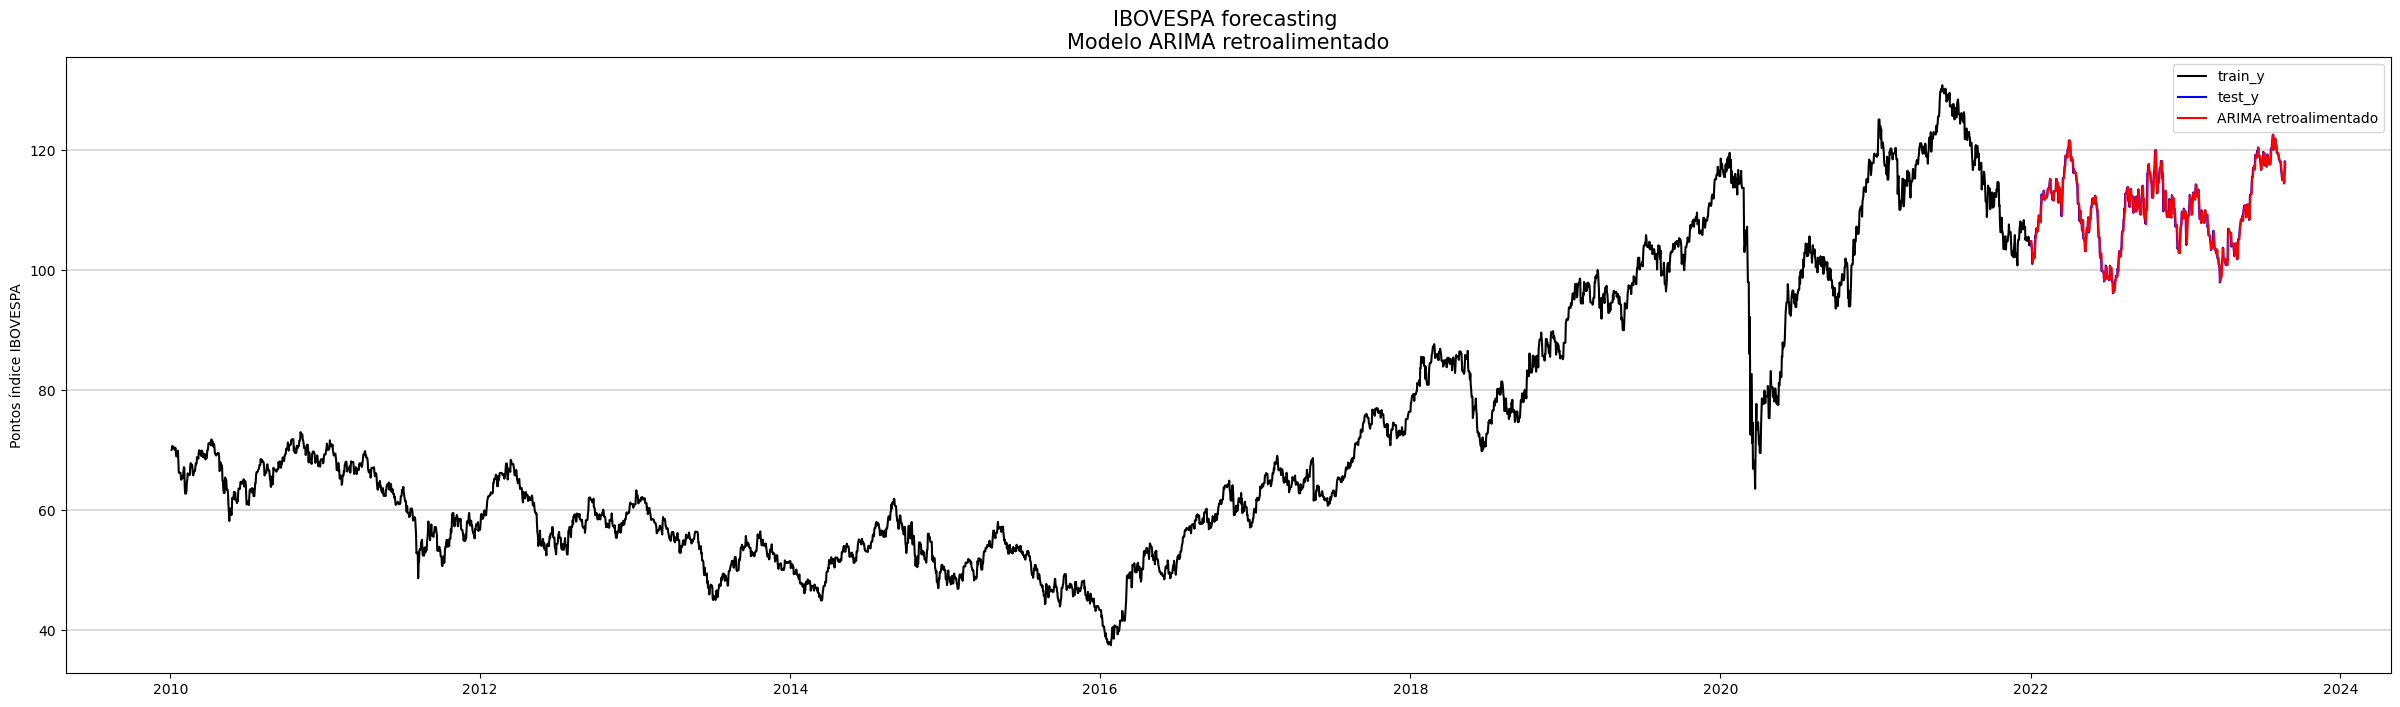

ARIMA retroalimentado WMAPE: 0.70%
ARIMA retroalimentado Test RMSE: 1.15
ARIMA retroalimentado MAE: 0.77


In [91]:
model_ = 'ARIMA retroalimentado'

fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(train_set_date_index, x='ds', y='y', ax=ax, label='train_y', color='black')
sns.lineplot(test_set_date_index, x='ds', y='y', ax=ax, color='blue', label='test_y')
sns.lineplot(y_pred, x='ds', y='y', ax=ax, color='red', label=f'{model_}')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title(f'IBOVESPA forecasting \nModelo {model_}', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

wmape_ = calc_wmape(test_set_date_index.y.values, y_pred.y.values)
rmse_ = sqrt(mean_squared_error(test_set_date_index.y.values, y_pred.y.values))
mae_ = calc_mae(test_set_date_index.y.values, y_pred.y.values)

print(f'{model_} WMAPE: {wmape_:.2%}')
print(f'{model_} Test RMSE: %.2f' % rmse_)
print(f'{model_} MAE: %.2f' % mae_)

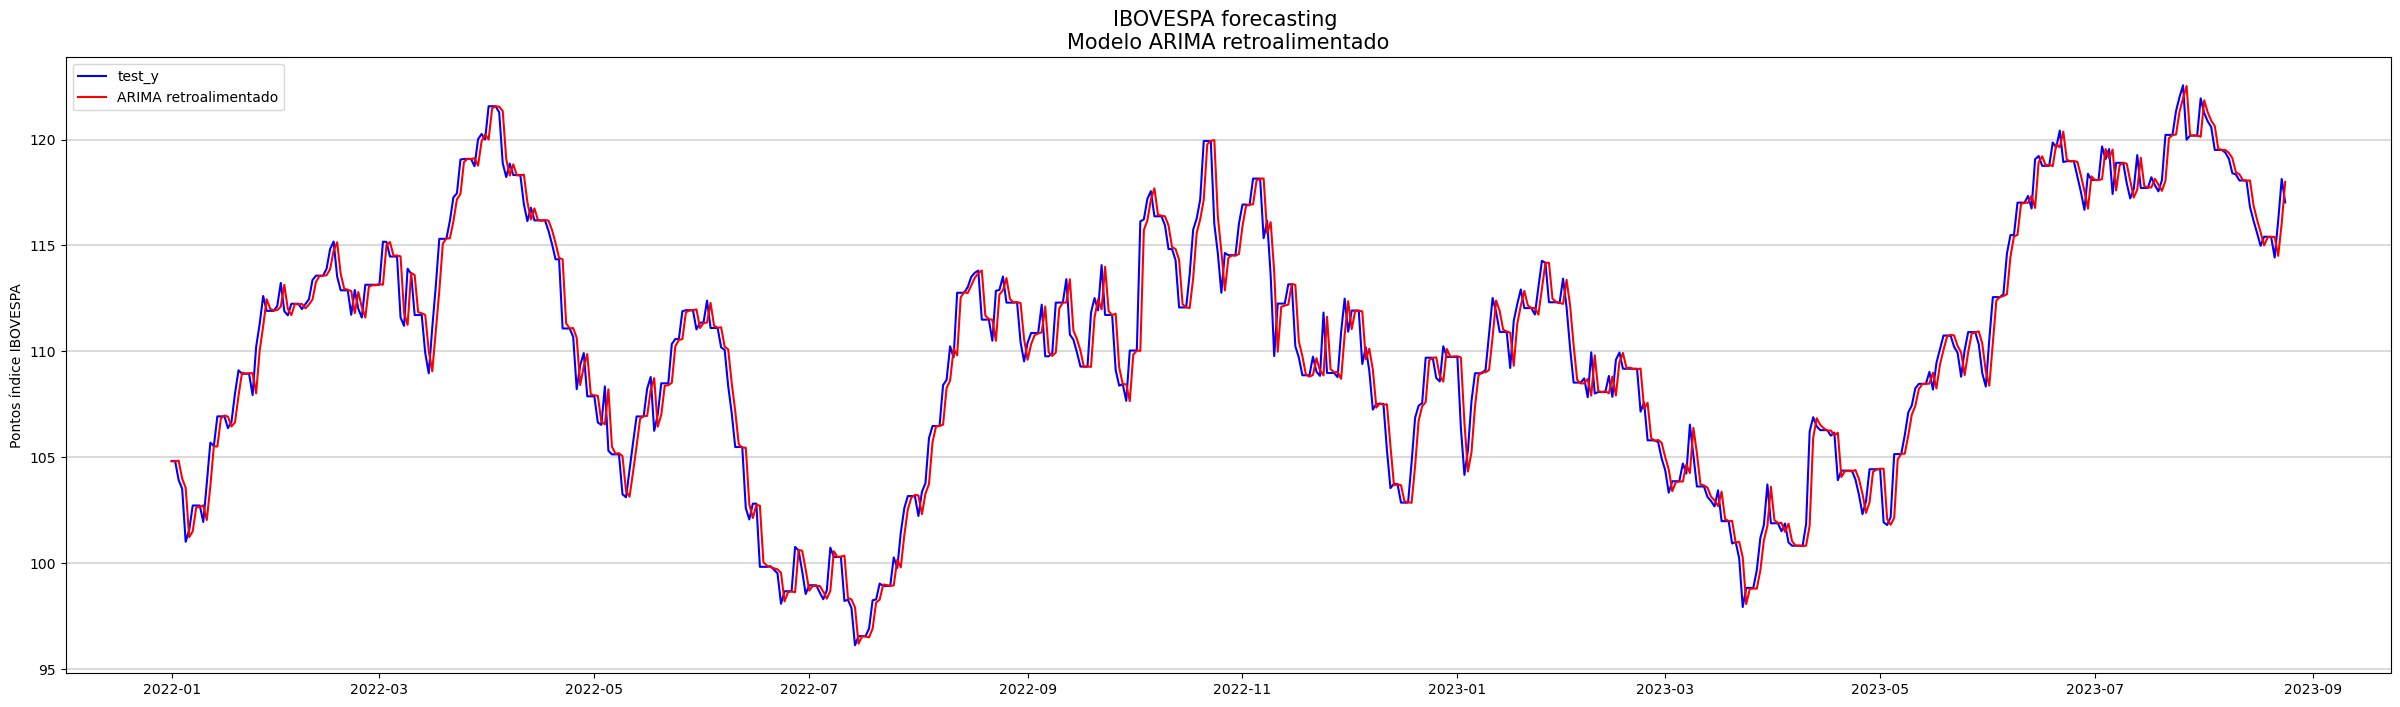

ARIMA retroalimentado WMAPE: 0.70%
ARIMA retroalimentado Test RMSE: 1.15
ARIMA retroalimentado MAE: 0.77


In [92]:
model_ = 'ARIMA retroalimentado'

fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(test_set_date_index, x='ds', y='y', ax=ax, color='blue', label='test_y')
sns.lineplot(y_pred, x='ds', y='y', ax=ax, color='red', label=f'{model_}')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title(f'IBOVESPA forecasting \nModelo {model_}', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

wmape_ = calc_wmape(test_set_date_index.y.values, y_pred.y.values)
rmse_ = sqrt(mean_squared_error(test_set_date_index.y.values, y_pred.y.values))
mae_ = calc_mae(test_set_date_index.y.values, y_pred.y.values)

print(f'{model_} WMAPE: {wmape_:.2%}')
print(f'{model_} Test RMSE: %.2f' % rmse_)
print(f'{model_} MAE: %.2f' % mae_)

In [93]:
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4980
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -6932.338
Date:                Sat, 02 Sep 2023   AIC                          13876.676
Time:                        12:04:36   BIC                          13915.754
Sample:                    01-04-2010   HQIC                         13890.375
                         - 08-23-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0658      0.006    -10.726      0.000      -0.078      -0.054
ar.L2         -0.0039      0.007     -0.588      0.556      -0.017       0.009
ar.L3          0.0018      0.007      0.262      0.793      -0.012       0.016
ar.L4          0.0198      0.007      2.772      0.006       0.006       0.034
ar.L5         -0.0059      0.008     -0.741      0.459      -0.022       0.010
sigma2         0.9481      0.007    131.699      0.000       0.934       0.962
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             93863.58
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               4.42   Skew:                            -1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""